In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tres.impl_at1 as tres
import torch


mhsa = tres.MultiHeadSelfAttentionBlock()
ffn = tres.FeedForwardNetworkBlock()
trans = tres.TransformerBlock()

#zakładamy że jest to już po flatten
testData = torch.rand((1,32,64))


print("input shape: ", testData.shape)

omsa = mhsa.forward(testData)

print("msa output shape: ", omsa.shape)

offn = ffn.forward(omsa)

print("ffn output shape: ", offn.shape)

otrans = trans.forward(testData)

print("transformer output shape: ", otrans.shape)


input shape:  torch.Size([1, 32, 64])
msa output shape:  torch.Size([1, 32, 64])
ffn output shape:  torch.Size([1, 32, 64])
transformer output shape:  torch.Size([1, 32, 64])


In [5]:
from torchvision.models import resnet50, ResNet50_Weights

resnet_weights = ResNet50_Weights.IMAGENET1K_V2

resnet = resnet50(resnet_weights)

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [7]:
from torchinfo import summary
def printModelData(model):
  print(summary(
    model=model,
    input_size=(1,3,224,224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    row_settings=['var_names']))

In [6]:
printModelData(resnet)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    │ 

In [7]:

resnetBlocks  = tres.createPretrainedResnet50Blocks(weights=resnet_weights)

# resnetBlocks  = Resnet50Blocks()
# resnet.load_state_dict(resnet_weights.get_state_dict(progress=True, check_hash=True))


In [8]:
printModelData(resnetBlocks)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
Resnet50Blocks (Resnet50Blocks)          [1, 3, 224, 224]          [1, 256, 56, 56]          2,049,000                 True
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    │ 

In [9]:
img = torch.rand(1,3,224,224)

In [10]:
resnet.to('cpu')
r1 = resnet.forward(img)
r1.shape

torch.Size([1, 1000])

In [11]:
resnetBlocks.cpu()

l1,l2,l3,l4 = resnetBlocks.forward(img)

print("l1 shape: ", l1.shape)
print("l2 shape: ", l2.shape)
print("l3 shape: ", l3.shape)
print("l4 shape: ", l4.shape)

l1 shape:  torch.Size([1, 256, 56, 56])
l2 shape:  torch.Size([1, 512, 28, 28])
l3 shape:  torch.Size([1, 1024, 14, 14])
l4 shape:  torch.Size([1, 2048, 7, 7])


In [8]:
from torch import nn

ap = nn.AdaptiveAvgPool2d((7,7))

In [13]:
ol = ap.forward(l1)
ol4 = ap.forward(l4)
c = torch.cat((ol, ol4), dim=1)
print(ol.shape)
print(ol4.shape)
print(c.shape)

torch.Size([1, 256, 7, 7])
torch.Size([1, 2048, 7, 7])
torch.Size([1, 2304, 7, 7])


In [4]:
import gc

def testMtres():
    img = torch.rand(3,3,224,224)
    print(img.min())
    print(img.max())
    mtres = tres.Tres()
    print(mtres.forward(img))
    del mtres
    gc.collect()

In [15]:
testMtres()

tensor(2.9802e-07)
tensor(1.0000)
x tres Is nan: False  min: 2.980232238769531e-07  max: 0.9999980926513672
l1 org Is nan: False  min: 0.0  max: 239.6754150390625
x Is nan: False  min: 0.0  max: 0.8793352246284485
dot Is nan: False  min: 0.0  max: 0.7732304334640503
conv Is nan: False  min: 0.0  max: 0.6461158394813538
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.8038133382797241
x Is nan: False  min: 0.0  max: 0.7266780734062195
dot Is nan: False  min: 0.0  max: 0.528061032295227
conv Is nan: False  min: 0.0  max: 0.424150288105011
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.6512682437896729
x Is nan: False  min: 0.0  max: 0.8524810075759888
dot Is nan: False  min: 0.0  max: 0.726723849773407
conv Is nan: False  min: 0.0  max: 0.5456831455230713
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.7387036681175232
x Is nan: False  min: 0.0  max: 0.9206472635269165
dot Is nan: False  min: 0.0  max: 0.8475914001464844
conv Is nan: False  min: 0.0  max: 0.629898428

In [16]:
t = torch.rand((1,3840,7,7))
print(t.shape)
t = nn.Flatten(2,3).forward(t)
print(t.shape)
t = t.permute(0,2,1)
print(t.shape)

trans = tres.TransformerBlock(embedd_dim=3840)

ot = trans.forward(t)
print(ot.shape)


# lin = nn.Linear(3840,64)
# t = lin.forward(t)
# print(t.shape)

torch.Size([1, 3840, 7, 7])
torch.Size([1, 3840, 49])
torch.Size([1, 49, 3840])
torch.Size([1, 49, 3840])


In [17]:
torch.rand((1,2,3,3))

tensor([[[[0.7459, 0.1869, 0.5882],
          [0.6222, 0.2332, 0.6194],
          [0.4888, 0.1123, 0.0904]],

         [[0.2236, 0.7142, 0.5658],
          [0.5425, 0.0453, 0.5687],
          [0.7955, 0.1967, 0.7641]]]])

In [18]:
r = torch.rand((1,49,3840))
print(r.shape)
z = torch.zeros(r.shape)
print(z.shape)

torch.Size([1, 49, 3840])
torch.Size([1, 49, 3840])


tensor([0., 1., 2., 3., 4., 5., 6.])
tensor([[0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.],
        [0., 1., 2., 3., 4., 5., 6.]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5.],
        [6., 6., 6., 6., 6., 6., 6.]])
tensor([[0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 3.1416, 4.1888, 5.2360, 6.2832],
        [0.0000, 1.0472, 2.0944, 

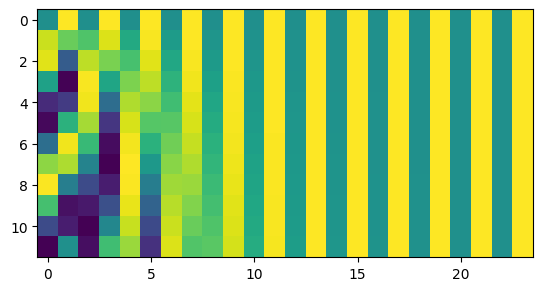

In [19]:
import matplotlib.pyplot as plt

xi = torch.arange(7, dtype=torch.float32)
print(xi)
x = torch.zeros((7,7))
x[:,:] = xi
y = x.t()
print(x)
print(y)

x = x / x.max() * 2 * torch.pi
print(x)

items = 12
dmodel = 24
n = 10000

d = torch.arange(items, dtype=torch.float32).unsqueeze(1)
print(d)
i = torch.arange(dmodel //2 , dtype=torch.float32)
print(i)
denom = torch.pow(n, (2 * i) / dmodel)
emb = torch.zeros(items,dmodel)
emb[:,0::2] = torch.sin(d / denom)
emb[:,1::2] = torch.cos(d / denom)
print(emb)
plt.imshow(emb)

In [20]:
from tres.impl_at1 import PosSineEncoding

def testPosSine(s = 7,dim = 3840):
    siner = PosSineEncoding(s,dim)
    t = torch.zeros((s,s,dim))

    print(t.shape)
    t = siner.forward(t)
    print(t.shape)

    plt.figure()
    plt.imshow(t[:,:,:,0].squeeze(0))
    plt.figure()
    plt.imshow(t[:,:,:,dim//2].squeeze(0))
    plt.figure()
    plt.imshow(t[:,-1,:,:].squeeze(0))

    del siner
    del t
    gc.collect()

In [21]:
testPosSine(7,36)

torch.Size([7, 7, 36])


RuntimeError: The size of tensor a (7) must match the size of tensor b (49) at non-singleton dimension 1

In [5]:
from Datasets.CLIVEDataset import CLIVEDataset, CLIVE_PATH
from torch import nn
from torchvision.transforms import v2

trans = v2.Compose([
    v2.RandomHorizontalFlip(0.25),
    v2.RandomVerticalFlip(0.25),
    v2.RandomCrop((224,224)),
    # v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
transTest = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])
transTest2 = v2.Compose([
    v2.RandomCrop((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])


trainDataset = CLIVEDataset(CLIVE_PATH, True,trans)
testDataset = CLIVEDataset(CLIVE_PATH, False,transTest2)

/home/mrpaw/.local/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [6]:
from torch.utils.data import DataLoader

batch_size = 32
trainDataLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True,num_workers=2)
testDataLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=True,num_workers=2)

In [7]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
cpu = 'cpu'
device

'cuda'

In [8]:
from helpers.trainer import trainLoop

/home/mrpaw/Documents/Projects/Python/PytorchTestRocm/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
model = tres.Tres()

In [33]:
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [43]:
printModelData(model)

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
Tres (Tres)                                   [1, 3, 224, 224]          [1, 1]                    7,870,465                 True
├─Resnet50Blocks (cnn)                        --                        --                        2,049,000                 True
│    └─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
│    └─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
│    └─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
│    └─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
│    └─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]        

In [37]:
torch.autograd.set_detect_anomaly(False)

In [29]:

imgs, lbls = next(iter(trainDataLoader))
print(imgs.shape)
print(imgs.max())
print(imgs.min())
print(lbls.shape)
res = model.cpu().forward(imgs)
print(res.shape)
print(res)

torch.Size([16, 3, 224, 224])
tensor(1.)
tensor(0.)
torch.Size([16, 1])
x tres Is nan: False  min: 0.0  max: 1.0
l1 org Is nan: False  min: 0.0  max: 119.70817565917969
x Is nan: False  min: 0.0  max: 0.8599557876586914
dot Is nan: False  min: 0.0  max: 0.7395239472389221
conv Is nan: False  min: 0.0  max: 0.5495867133140564
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.7413411736488342
x Is nan: False  min: 0.0  max: 0.8140363097190857
dot Is nan: False  min: 0.0  max: 0.6626551151275635
conv Is nan: False  min: 0.0  max: 0.4942922592163086
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.703059196472168
x Is nan: False  min: 0.0  max: 0.5395818948745728
dot Is nan: False  min: 0.0  max: 0.2911486327648163
conv Is nan: False  min: 0.0  max: 0.2453397512435913
sqrt Is nan: False  min: 9.999999974752427e-07  max: 0.49531781673431396
x Is nan: False  min: 0.0  max: 0.9985070824623108
dot Is nan: False  min: 0.0  max: 0.9970163702964783
conv Is nan: False  min: 0.0  max: 0.

In [38]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-4)

In [29]:
# lossFn = nn.MSELoss()
lossFn = nn.L1Loss()

In [19]:
steps = 5 * 30

In [20]:
lrScheluder = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=2e-4, total_steps=steps)

  0%|          | 0/150 [00:00<?, ?it/s]

  Testing... 30/30, lr [8.000000000000005e-06], Avg Loss:0.3283743025927708, SRCC:0.07741862535476685, PLCC:0.0668654590845108, MAE:0.32006803154945374, COS:0.8010799288749695					
  Testing... 8/8, Avg Loss:0.2303123346396855, SRCC:0.08003568649291992, PLCC:0.06303419917821884, MAE:0.19929072260856628, COS:0.9308046698570251					


  1%|          | 1/150 [00:27<1:09:05, 27.82s/it]

  Testing... 30/30, lr [8.244596997415666e-06], Avg Loss:0.2062756110881937, SRCC:0.1233525276184082, PLCC:0.1397443413734436, MAE:0.20392493903636932, COS:0.9125864505767822							
  Testing... 8/8, Avg Loss:0.3063874010528837, SRCC:0.14413166046142578, PLCC:0.15322859585285187, MAE:0.26671674847602844, COS:0.9348194599151611				


  1%|▏         | 2/150 [00:55<1:08:19, 27.70s/it]

  Testing... 30/30, lr [8.977141579430463e-06], Avg Loss:0.18360779973967323, SRCC:0.23913782835006714, PLCC:0.24135954678058624, MAE:0.17755219340324402, COS:0.9293639063835144				
  Testing... 8/8, Avg Loss:0.26216279715299606, SRCC:0.26768916845321655, PLCC:0.26937785744667053, MAE:0.2424304336309433, COS:0.9397051930427551				


  2%|▏         | 3/150 [01:22<1:07:15, 27.45s/it]

  Testing... 30/30, lr [1.019390086676869e-05], Avg Loss:0.18922980386635352, SRCC:0.2677209973335266, PLCC:0.27998852729797363, MAE:0.17386901378631592, COS:0.9340099096298218					
  Testing... 8/8, Avg Loss:0.18966618606022426, SRCC:0.34473174810409546, PLCC:0.3161926865577698, MAE:0.16504348814487457, COS:0.9394057989120483				


  3%|▎         | 4/150 [01:49<1:06:34, 27.36s/it]

  Testing... 30/30, lr [1.1888674533008244e-05], Avg Loss:0.17016544270104375, SRCC:0.3261338472366333, PLCC:0.342490017414093, MAE:0.1617182344198227, COS:0.9398840665817261							
  Testing... 8/8, Avg Loss:0.18988971837929317, SRCC:0.34077292680740356, PLCC:0.3433825671672821, MAE:0.1688392609357834, COS:0.9397974014282227				


  3%|▎         | 5/150 [02:17<1:06:13, 27.40s/it]

  Testing... 30/30, lr [1.405282640002287e-05], Avg Loss:0.17065216986269788, SRCC:0.40372133255004883, PLCC:0.4235164523124695, MAE:0.16240650415420532, COS:0.9400777816772461					
  Testing... 8/8, Avg Loss:0.27190540730953217, SRCC:0.3824049234390259, PLCC:0.43247053027153015, MAE:0.23504111170768738, COS:0.947307288646698					


  4%|▍         | 6/150 [02:44<1:05:43, 27.39s/it]

  Testing... 30/30, lr [1.6675328445966238e-05], Avg Loss:0.17388643118841896, SRCC:0.39562535285949707, PLCC:0.43185335397720337, MAE:0.16844166815280914, COS:0.9385176301002502				
  Testing... 8/8, Avg Loss:0.17311410393033708, SRCC:0.4741939306259155, PLCC:0.489597886800766, MAE:0.15333391726016998, COS:0.9509538412094116				


  5%|▍         | 7/150 [03:12<1:05:27, 27.47s/it]

  Testing... 30/30, lr [1.974281700154346e-05], Avg Loss:0.15158270659117862, SRCC:0.5006537437438965, PLCC:0.5320416688919067, MAE:0.14518095552921295, COS:0.9513599276542664				
  Testing... 8/8, Avg Loss:0.22698023276669638, SRCC:0.500118613243103, PLCC:0.5422064065933228, MAE:0.19144712388515472, COS:0.9541547298431396					


  5%|▌         | 8/150 [03:39<1:05:06, 27.51s/it]

  Testing... 30/30, lr [2.32396608482066e-05], Avg Loss:0.1748060447902515, SRCC:0.4203528165817261, PLCC:0.45999374985694885, MAE:0.17411081492900848, COS:0.9345609545707703				
  Testing... 8/8, Avg Loss:0.573134320122855, SRCC:0.5095001459121704, PLCC:0.5161020159721375, MAE:0.48935678601264954, COS:0.9498208165168762						


  6%|▌         | 9/150 [04:07<1:04:34, 27.48s/it]

  Testing... 30/30, lr [2.7148040871261404e-05], Avg Loss:0.19564683915212236, SRCC:0.4049186110496521, PLCC:0.445237934589386, MAE:0.19279424846172333, COS:0.9242263436317444				
  Testing... 8/8, Avg Loss:0.4982283455984933, SRCC:0.4967687726020813, PLCC:0.5524023175239563, MAE:0.4393496513366699, COS:0.9534540772438049				


  7%|▋         | 10/150 [04:35<1:04:23, 27.59s/it]

  Testing... 30/30, lr [3.14480408619912e-05], Avg Loss:0.183730434240966, SRCC:0.488910436630249, PLCC:0.5309290885925293, MAE:0.17433808743953705, COS:0.9376893043518066							
  Testing... 8/8, Avg Loss:0.3007058245795114, SRCC:0.5731539726257324, PLCC:0.6330996155738831, MAE:0.2616107165813446, COS:0.9593356847763062				


  7%|▋         | 11/150 [05:03<1:04:08, 27.69s/it]

  Testing... 30/30, lr [3.611774900609145e-05], Avg Loss:0.1908441388915325, SRCC:0.416009783744812, PLCC:0.4679231345653534, MAE:0.1882580667734146, COS:0.9268860816955566				9				
  Testing... 8/8, Avg Loss:0.18398543021508626, SRCC:0.5706522464752197, PLCC:0.6223676204681396, MAE:0.1546863317489624, COS:0.9599118232727051					


  8%|▊         | 12/150 [05:30<1:03:24, 27.57s/it]

  Testing... 30/30, lr [4.1133369541252634e-05], Avg Loss:0.12435295484189329, SRCC:0.6245642304420471, PLCC:0.6843418478965759, MAE:0.1217867061495781, COS:0.9659684896469116					
  Testing... 8/8, Avg Loss:0.7116662093571254, SRCC:0.6479291915893555, PLCC:0.6900580525398254, MAE:0.622710645198822, COS:0.9584072232246399					


  9%|▊         | 13/150 [05:57<1:02:59, 27.59s/it]

  Testing... 30/30, lr [4.646934401491071e-05], Avg Loss:0.23107371273739585, SRCC:0.3974401354789734, PLCC:0.4442031681537628, MAE:0.2213217318058014, COS:0.9106937050819397				
  Testing... 8/8, Avg Loss:0.25074062815734316, SRCC:0.5551024079322815, PLCC:0.6446916460990906, MAE:0.21303823590278625, COS:0.9596771001815796				


  9%|▉         | 14/150 [06:25<1:02:26, 27.55s/it]

  Testing... 30/30, lr [5.209848152426262e-05], Avg Loss:0.17138493395057217, SRCC:0.5514194369316101, PLCC:0.5826795101165771, MAE:0.16393399238586426, COS:0.9445919394493103				
  Testing... 8/8, Avg Loss:0.14682747104338237, SRCC:0.6253752112388611, PLCC:0.6690133213996887, MAE:0.1262802928686142, COS:0.963737964630127						


 10%|█         | 15/150 [06:52<1:01:56, 27.53s/it]

  Testing... 30/30, lr [5.799209727487455e-05], Avg Loss:0.13053494486315498, SRCC:0.658942699432373, PLCC:0.7088984251022339, MAE:0.1264236867427826, COS:0.965438187122345							
  Testing... 8/8, Avg Loss:0.3255743661097118, SRCC:0.5928515195846558, PLCC:0.6509203314781189, MAE:0.2885688543319702, COS:0.9607003927230835				


 11%|█         | 16/150 [07:20<1:01:32, 27.56s/it]

  Testing... 30/30, lr [6.41201587518189e-05], Avg Loss:0.1540983827977345, SRCC:0.60843825340271, PLCC:0.6459622979164124, MAE:0.14556698501110077, COS:0.9544322490692139							
  Testing... 8/8, Avg Loss:0.16281594974654062, SRCC:0.6233013868331909, PLCC:0.6794125437736511, MAE:0.14124643802642822, COS:0.9650749564170837				


 11%|█▏        | 17/150 [07:48<1:01:24, 27.70s/it]

  Testing... 30/30, lr [7.045143875848654e-05], Avg Loss:0.22427476094714527, SRCC:0.4625662565231323, PLCC:0.4975428283214569, MAE:0.22052739560604095, COS:0.9083381295204163				
  Testing... 8/8, Avg Loss:0.27186304117952076, SRCC:0.6361361145973206, PLCC:0.6750302314758301, MAE:0.2393871694803238, COS:0.9630573987960815				


 12%|█▏        | 18/150 [08:16<1:00:58, 27.72s/it]

  Testing... 30/30, lr [7.695367454322276e-05], Avg Loss:0.16499643747148843, SRCC:0.5594763159751892, PLCC:0.6086056232452393, MAE:0.16253672540187836, COS:0.944847583770752				
  Testing... 8/8, Avg Loss:0.7282193899154663, SRCC:0.6127027273178101, PLCC:0.6641758680343628, MAE:0.6383253931999207, COS:0.9571993350982666				


 13%|█▎        | 19/150 [08:44<1:00:30, 27.71s/it]

  Testing... 30/30, lr [8.359373220291425e-05], Avg Loss:0.2964907232029685, SRCC:0.3933507204055786, PLCC:0.4397861957550049, MAE:0.28893551230430603, COS:0.8634787201881409					
  Testing... 8/8, Avg Loss:0.6071695600237165, SRCC:0.612604022026062, PLCC:0.6713280081748962, MAE:0.5341668725013733, COS:0.9562227129936218				


 13%|█▎        | 20/150 [09:11<1:00:04, 27.73s/it]

  Testing... 30/30, lr [9.033777552576462e-05], Avg Loss:0.2170636212003642, SRCC:0.47124242782592773, PLCC:0.5201995372772217, MAE:0.21106594800949097, COS:0.9195660948753357				
  Testing... 8/8, Avg Loss:0.49073789375168936, SRCC:0.6558175086975098, PLCC:0.7028080224990845, MAE:0.4274003803730011, COS:0.961182177066803					


 14%|█▍        | 21/150 [09:39<59:51, 27.84s/it]  

  Testing... 30/30, lr [9.71514384128737e-05], Avg Loss:0.19929669848803816, SRCC:0.48511648178100586, PLCC:0.5343367457389832, MAE:0.18832789361476898, COS:0.9277688264846802				
  Testing... 8/8, Avg Loss:0.37590499009404865, SRCC:0.6810116767883301, PLCC:0.7277018427848816, MAE:0.3289041221141815, COS:0.9659715890884399				


 15%|█▍        | 22/150 [10:07<59:11, 27.75s/it]

  Testing... 30/30, lr [0.00010400000000000001], Avg Loss:0.12214494034134109, SRCC:0.6981587409973145, PLCC:0.7394304275512695, MAE:0.11628776043653488, COS:0.970181941986084				
  Testing... 8/8, Avg Loss:0.32499864271708895, SRCC:0.7103203535079956, PLCC:0.7372766733169556, MAE:0.2879370450973511, COS:0.9664591550827026				


 15%|█▌        | 23/150 [10:35<58:46, 27.77s/it]

  Testing... 30/30, lr [0.00011084856158712631], Avg Loss:0.14889900925858268, SRCC:0.5991108417510986, PLCC:0.657368004322052, MAE:0.14555545151233673, COS:0.9586083889007568					
  Testing... 8/8, Avg Loss:0.30811864563397, SRCC:0.7219910621643066, PLCC:0.7728101015090942, MAE:0.27220866084098816, COS:0.9454407691955566					


 16%|█▌        | 24/150 [11:02<58:10, 27.70s/it]

  Testing... 30/30, lr [0.00011766222447423537], Avg Loss:0.17595925027954168, SRCC:0.5542466640472412, PLCC:0.5891964435577393, MAE:0.173789843916893, COS:0.9392614364624023						
  Testing... 8/8, Avg Loss:0.307570572410311, SRCC:0.6906247138977051, PLCC:0.7487340569496155, MAE:0.26917764544487, COS:0.968640148639679							


 17%|█▋        | 25/150 [11:30<57:38, 27.67s/it]

  Testing... 30/30, lr [0.00012440626779708578], Avg Loss:0.12180547981426634, SRCC:0.7123441100120544, PLCC:0.749272346496582, MAE:0.11901179701089859, COS:0.9697043299674988					
  Testing... 8/8, Avg Loss:0.39913795249802725, SRCC:0.7253541350364685, PLCC:0.7595916390419006, MAE:0.3415972590446472, COS:0.9124005436897278					


 17%|█▋        | 26/150 [11:58<57:11, 27.67s/it]

  Testing... 30/30, lr [0.00013104632545677726], Avg Loss:0.24578504341429677, SRCC:0.3901779055595398, PLCC:0.4377364218235016, MAE:0.24487705528736115, COS:0.8811888694763184				
  Testing... 8/8, Avg Loss:0.4816114008426666, SRCC:0.7268340587615967, PLCC:0.7719407081604004, MAE:0.4209907054901123, COS:0.763334333896637				


 18%|█▊        | 27/150 [12:26<57:05, 27.85s/it]

  Testing... 30/30, lr [0.00013754856124151345], Avg Loss:0.1811504733973536, SRCC:0.5109419226646423, PLCC:0.5595934391021729, MAE:0.17666298151016235, COS:0.9305493831634521						
  Testing... 8/8, Avg Loss:0.17396534979343414, SRCC:0.7009634971618652, PLCC:0.7483158111572266, MAE:0.15270684659481049, COS:0.971836268901825				


 19%|█▊        | 28/150 [12:53<56:27, 27.77s/it]

  Testing... 30/30, lr [0.0001438798412481811], Avg Loss:0.12342709919501996, SRCC:0.7272101640701294, PLCC:0.7538638710975647, MAE:0.10952560603618622, COS:0.9731045365333557				
  Testing... 8/8, Avg Loss:0.1202700776713235, SRCC:0.712700605392456, PLCC:0.7788711786270142, MAE:0.10734812915325165, COS:0.9744077324867249						


 19%|█▉        | 29/150 [13:21<55:57, 27.75s/it]

  Testing... 30/30, lr [0.00015000790272512543], Avg Loss:0.1205691517940883, SRCC:0.7462455034255981, PLCC:0.7715941667556763, MAE:0.11064165830612183, COS:0.9732539653778076					
  Testing... 8/8, Avg Loss:0.11747178861073085, SRCC:0.7395787239074707, PLCC:0.7925500869750977, MAE:0.10157740116119385, COS:0.9758446216583252				


 20%|██        | 30/150 [13:49<55:37, 27.82s/it]

  Testing... 30/30, lr [0.00015590151847573734], Avg Loss:0.09469966564712853, SRCC:0.8010885715484619, PLCC:0.8260995149612427, MAE:0.09206090122461319, COS:0.9806477427482605				
  Testing... 8/8, Avg Loss:0.15707182777779444, SRCC:0.7131123542785645, PLCC:0.7423679232597351, MAE:0.13380415737628937, COS:0.9703793525695801				


 21%|██        | 31/150 [14:12<52:28, 26.46s/it]

  Testing... 30/30, lr [0.0001615306559850893], Avg Loss:0.10195400026337854, SRCC:0.8095433712005615, PLCC:0.8280172944068909, MAE:0.0893673375248909, COS:0.9811692237854004					
  Testing... 8/8, Avg Loss:0.11624402020658765, SRCC:0.765549898147583, PLCC:0.8020638823509216, MAE:0.102877676486969, COS:0.9768600463867188						


 21%|██▏       | 32/150 [14:36<50:14, 25.54s/it]

  Testing... 30/30, lr [0.00016686663045874738], Avg Loss:0.10321844343481393, SRCC:0.8010841608047485, PLCC:0.8232771754264832, MAE:0.09381789714097977, COS:0.9796261191368103				
  Testing... 8/8, Avg Loss:0.20106156170368195, SRCC:0.6724612712860107, PLCC:0.7510996460914612, MAE:0.172359898686409, COS:0.9705905914306641				


 22%|██▏       | 33/150 [14:59<48:35, 24.92s/it]

  Testing... 30/30, lr [0.00017188225099390856], Avg Loss:0.0962530425910292, SRCC:0.8303285241127014, PLCC:0.846347987651825, MAE:0.08621498197317123, COS:0.9828874468803406						
  Testing... 8/8, Avg Loss:0.11956433419670377, SRCC:0.7585106492042542, PLCC:0.7908272743225098, MAE:0.10256496071815491, COS:0.9760668873786926				


 23%|██▎       | 34/150 [15:23<47:21, 24.50s/it]

  Testing... 30/30, lr [0.0001765519591380088], Avg Loss:0.10714434190043087, SRCC:0.79221111536026, PLCC:0.8119688630104065, MAE:0.09750644862651825, COS:0.978659451007843							
  Testing... 8/8, Avg Loss:0.1682063958474568, SRCC:0.7405786514282227, PLCC:0.7717474102973938, MAE:0.14574329555034637, COS:0.9729174971580505					


 23%|██▎       | 35/150 [15:46<46:24, 24.21s/it]

  Testing... 30/30, lr [0.0001808519591287386], Avg Loss:0.09721420242868621, SRCC:0.8094083070755005, PLCC:0.8231801986694336, MAE:0.09417837858200073, COS:0.9800118207931519				
  Testing... 8/8, Avg Loss:0.19207538025719778, SRCC:0.7322890162467957, PLCC:0.7713395953178406, MAE:0.1638634204864502, COS:0.9697860479354858				


 24%|██▍       | 36/150 [16:10<45:31, 23.96s/it]

  Testing... 30/30, lr [0.00018476033915179341], Avg Loss:0.1225703383057282, SRCC:0.7177742123603821, PLCC:0.7521044015884399, MAE:0.12074025720357895, COS:0.9696677923202515					
  Testing... 8/8, Avg Loss:0.199926352926663, SRCC:0.7203953862190247, PLCC:0.7545678019523621, MAE:0.1713014394044876, COS:0.9712553024291992							


 25%|██▍       | 37/150 [16:33<44:46, 23.78s/it]

  Testing... 30/30, lr [0.00018825718299845655], Avg Loss:0.10258300589590237, SRCC:0.8266426920890808, PLCC:0.8434562087059021, MAE:0.08472750335931778, COS:0.9827213287353516				
  Testing... 8/8, Avg Loss:0.11330044216343335, SRCC:0.7414722442626953, PLCC:0.7957504987716675, MAE:0.10321792960166931, COS:0.9758139848709106				


 25%|██▌       | 38/150 [16:56<44:09, 23.66s/it]

  Testing... 30/30, lr [0.00019132467155403378], Avg Loss:0.08835597105067351, SRCC:0.8186668157577515, PLCC:0.8394023776054382, MAE:0.0875367522239685, COS:0.9818158149719238					
  Testing... 8/8, Avg Loss:0.24712779692241124, SRCC:0.7921699285507202, PLCC:0.8229636549949646, MAE:0.2161261886358261, COS:0.9758889079093933				


 26%|██▌       | 39/150 [17:20<43:37, 23.58s/it]

  Testing... 30/30, lr [0.00019394717359997712], Avg Loss:0.09798601231184499, SRCC:0.8014124035835266, PLCC:0.8242444396018982, MAE:0.09532772749662399, COS:0.9795371294021606				
  Testing... 8/8, Avg Loss:0.3072217106819153, SRCC:0.6852637529373169, PLCC:0.738569974899292, MAE:0.26534610986709595, COS:0.9675326347351074				


 27%|██▋       | 40/150 [17:43<43:11, 23.56s/it]

  Testing... 30/30, lr [0.00019611132546699174], Avg Loss:0.11439447515997393, SRCC:0.7924528121948242, PLCC:0.8051642179489136, MAE:0.09817959368228912, COS:0.9782044291496277				
  Testing... 8/8, Avg Loss:0.13910969772509166, SRCC:0.7532312273979187, PLCC:0.792089581489563, MAE:0.12465417385101318, COS:0.976254940032959						


 27%|██▋       | 41/150 [18:07<42:40, 23.49s/it]

  Testing... 30/30, lr [0.00019780609913323132], Avg Loss:0.0879429717516077, SRCC:0.8404805064201355, PLCC:0.8534250855445862, MAE:0.08387679606676102, COS:0.9833688735961914					
  Testing... 8/8, Avg Loss:0.12233956477471761, SRCC:0.7189552783966064, PLCC:0.7825285196304321, MAE:0.10828260332345963, COS:0.9748411774635315				


 28%|██▊       | 42/150 [18:30<42:14, 23.47s/it]

  Testing... 30/30, lr [0.00019902285842056955], Avg Loss:0.085970856506249, SRCC:0.8508369326591492, PLCC:0.870019793510437, MAE:0.07977703958749771, COS:0.9855196475982666							
  Testing... 8/8, Avg Loss:0.14116896369627543, SRCC:0.7219398021697998, PLCC:0.7603480219841003, MAE:0.12660935521125793, COS:0.9725798964500427				


 29%|██▊       | 43/150 [18:53<41:46, 23.42s/it]

  Testing... 30/30, lr [0.00019975540300258435], Avg Loss:0.08177404683725588, SRCC:0.8435690402984619, PLCC:0.8631210923194885, MAE:0.07966308295726776, COS:0.984822154045105				
  Testing... 8/8, Avg Loss:0.16709150586809432, SRCC:0.7617675065994263, PLCC:0.7859190106391907, MAE:0.1480838805437088, COS:0.9736807346343994				


 29%|██▉       | 44/150 [19:17<41:19, 23.39s/it]

  Testing... 30/30, lr [0.0002], Avg Loss:0.08168798466694766, SRCC:0.863610565662384, PLCC:0.8741559386253357, MAE:0.07945003360509872, COS:0.9855738878250122				
  Testing... 8/8, Avg Loss:0.13346274835722788, SRCC:0.7094247937202454, PLCC:0.7555922269821167, MAE:0.11584488302469254, COS:0.9726276993751526				


 30%|███       | 45/150 [19:40<40:55, 23.39s/it]

  Testing... 30/30, lr [0.00019995524340737743], Avg Loss:0.08190347164355476, SRCC:0.841454267501831, PLCC:0.8525605797767639, MAE:0.08089923113584518, COS:0.9837145209312439					
  Testing... 8/8, Avg Loss:0.1755879351070949, SRCC:0.7301772832870483, PLCC:0.7701285481452942, MAE:0.15387842059135437, COS:0.972481906414032						


 31%|███       | 46/150 [20:04<40:36, 23.43s/it]

  Testing... 30/30, lr [0.0001998210136927216], Avg Loss:0.10432708289088874, SRCC:0.7793203592300415, PLCC:0.8004747629165649, MAE:0.09832790493965149, COS:0.9774619340896606				
  Testing... 8/8, Avg Loss:0.3366910602365221, SRCC:0.7349851727485657, PLCC:0.7823873162269592, MAE:0.295840859413147, COS:0.9708095788955688					


 31%|███▏      | 47/150 [20:27<40:14, 23.44s/it]

  Testing... 30/30, lr [0.00019959743100980633], Avg Loss:0.1300334993364482, SRCC:0.7585105299949646, PLCC:0.7856521010398865, MAE:0.11305787414312363, COS:0.9734398722648621				
  Testing... 8/8, Avg Loss:0.1345847174525261, SRCC:0.6624004244804382, PLCC:0.6993237137794495, MAE:0.11942727118730545, COS:0.9667465090751648					


 32%|███▏      | 48/150 [20:51<39:53, 23.46s/it]

  Testing... 30/30, lr [0.0001992846954954132], Avg Loss:0.08473999284464738, SRCC:0.8446715474128723, PLCC:0.8551203608512878, MAE:0.08215983211994171, COS:0.9836811423301697				
  Testing... 8/8, Avg Loss:0.11373182705470494, SRCC:0.7646799087524414, PLCC:0.7946792244911194, MAE:0.0984514132142067, COS:0.9763625264167786					


 33%|███▎      | 49/150 [21:14<39:26, 23.43s/it]

  Testing... 30/30, lr [0.00019888308709018236], Avg Loss:0.09001762728238928, SRCC:0.8617745041847229, PLCC:0.8724097013473511, MAE:0.07737831771373749, COS:0.9858497381210327				
  Testing... 8/8, Avg Loss:0.11100878779377256, SRCC:0.7788352370262146, PLCC:0.8133087158203125, MAE:0.10054724663496017, COS:0.9784603118896484				


 33%|███▎      | 50/150 [21:37<39:01, 23.42s/it]

  Testing... 30/30, lr [0.00019839296528802755], Avg Loss:0.08306007048693197, SRCC:0.8714595437049866, PLCC:0.8791868686676025, MAE:0.07650308310985565, COS:0.9863583445549011				
  Testing... 8/8, Avg Loss:0.2856867675270353, SRCC:0.753280520439148, PLCC:0.8001943826675415, MAE:0.25182536244392395, COS:0.9738743901252747						


 34%|███▍      | 51/150 [22:01<38:37, 23.41s/it]

  Testing... 30/30, lr [0.00019781476881434028], Avg Loss:0.11268883622412024, SRCC:0.7564389109611511, PLCC:0.7831518054008484, MAE:0.10994978249073029, COS:0.9739545583724976				
  Testing... 8/8, Avg Loss:0.13484889268875122, SRCC:0.780753493309021, PLCC:0.8027393221855164, MAE:0.11972108483314514, COS:0.976403534412384				


 35%|███▍      | 52/150 [22:24<38:13, 23.40s/it]

  Testing... 30/30, lr [0.0001971490152332714], Avg Loss:0.09512824963392882, SRCC:0.8360829949378967, PLCC:0.8504567742347717, MAE:0.0871075987815857, COS:0.9830276370048523					
  Testing... 8/8, Avg Loss:0.31883099036557333, SRCC:0.753999650478363, PLCC:0.7992678880691528, MAE:0.274699330329895, COS:0.9714882373809814					


 35%|███▌      | 53/150 [22:47<37:49, 23.40s/it]

  Testing... 30/30, lr [0.00019639630048444106], Avg Loss:0.10924791223530111, SRCC:0.7585214376449585, PLCC:0.7797158360481262, MAE:0.10676410794258118, COS:0.9736799001693726				
  Testing... 8/8, Avg Loss:0.12316122651100159, SRCC:0.7644740343093872, PLCC:0.8114614486694336, MAE:0.11100904643535614, COS:0.9767017364501953				


 36%|███▌      | 54/150 [23:11<37:34, 23.48s/it]

  Testing... 30/30, lr [0.00019555729834949177], Avg Loss:0.07865644606022999, SRCC:0.8636127710342407, PLCC:0.8827264904975891, MAE:0.07596603035926819, COS:0.9868773221969604				
  Testing... 8/8, Avg Loss:0.17682621947356633, SRCC:0.7541855573654175, PLCC:0.7748534083366394, MAE:0.15718361735343933, COS:0.9730086922645569				


 37%|███▋      | 55/150 [23:35<37:07, 23.44s/it]

  Testing... 30/30, lr [0.00019463275984896291], Avg Loss:0.09287999262069833, SRCC:0.8313753008842468, PLCC:0.8435305953025818, MAE:0.09085752069950104, COS:0.9815971851348877				
  Testing... 8/8, Avg Loss:0.11406611651182175, SRCC:0.760208785533905, PLCC:0.7985629439353943, MAE:0.09825342148542404, COS:0.9766360521316528					


 37%|███▋      | 56/150 [23:58<36:40, 23.41s/it]

  Testing... 30/30, lr [0.00019362351257002549], Avg Loss:0.07955733969293792, SRCC:0.8888611197471619, PLCC:0.8958372473716736, MAE:0.06814825534820557, COS:0.9883713126182556				
  Testing... 8/8, Avg Loss:0.12969197758606502, SRCC:0.7758212685585022, PLCC:0.8205941319465637, MAE:0.10983102768659592, COS:0.9788075089454651				


 38%|███▊      | 57/150 [24:21<36:15, 23.39s/it]

  Testing... 30/30, lr [0.0001925304599256795], Avg Loss:0.08318822419848936, SRCC:0.8816413879394531, PLCC:0.8885303139686584, MAE:0.07282871007919312, COS:0.987540602684021					
  Testing... 8/8, Avg Loss:0.10869859478303365, SRCC:0.7843755483627319, PLCC:0.8251939415931702, MAE:0.09254815429449081, COS:0.9796266555786133				


 39%|███▊      | 58/150 [24:45<35:50, 23.38s/it]

  Testing... 30/30, lr [0.00019135458034607702], Avg Loss:0.08362232482638852, SRCC:0.8638951182365417, PLCC:0.8740578889846802, MAE:0.07656966894865036, COS:0.9859610795974731				
  Testing... 8/8, Avg Loss:0.16772559817348207, SRCC:0.7451446056365967, PLCC:0.787004292011261, MAE:0.14369769394397736, COS:0.9734756946563721				


 39%|███▉      | 59/150 [25:08<35:26, 23.37s/it]

  Testing... 30/30, lr [0.00019009692640269474], Avg Loss:0.08794363331178139, SRCC:0.8555948734283447, PLCC:0.869769275188446, MAE:0.08009874820709229, COS:0.9850411415100098					
  Testing... 8/8, Avg Loss:0.11289479583501816, SRCC:0.7879729866981506, PLCC:0.8137330412864685, MAE:0.10015381872653961, COS:0.9775795936584473				


 40%|████      | 60/150 [25:31<35:06, 23.40s/it]

  Testing... 30/30, lr [0.00018875862386613982], Avg Loss:0.07525460691801433, SRCC:0.9000759124755859, PLCC:0.9025408625602722, MAE:0.06694361567497253, COS:0.9891154766082764				
  Testing... 8/8, Avg Loss:0.11572235503367015, SRCC:0.8209425806999207, PLCC:0.8296852707862854, MAE:0.10051526874303818, COS:0.9801906943321228				


 41%|████      | 61/150 [25:55<34:42, 23.40s/it]

  Testing... 30/30, lr [0.00018734087069843274], Avg Loss:0.07952566855940325, SRCC:0.8728973269462585, PLCC:0.8776292204856873, MAE:0.07756716012954712, COS:0.9858675599098206				
  Testing... 8/8, Avg Loss:0.12288566998073033, SRCC:0.7616365551948547, PLCC:0.7989436388015747, MAE:0.10769219696521759, COS:0.976055383682251					


 41%|████▏     | 62/150 [26:18<34:18, 23.39s/it]

  Testing... 30/30, lr [0.00018584493598066917], Avg Loss:0.06801173540538755, SRCC:0.8930214643478394, PLCC:0.8966836333274841, MAE:0.06733004003763199, COS:0.9884563684463501				
  Testing... 8/8, Avg Loss:0.2036505000931876, SRCC:0.745823860168457, PLCC:0.7843047380447388, MAE:0.18073301017284393, COS:0.971832811832428							


 42%|████▏     | 63/150 [26:41<33:52, 23.36s/it]

  Testing... 30/30, lr [0.00018427215877702048], Avg Loss:0.10482757448636253, SRCC:0.8070273399353027, PLCC:0.8246771097183228, MAE:0.09265026450157166, COS:0.9799685478210449				
  Testing... 8/8, Avg Loss:0.11921618772404534, SRCC:0.7292001247406006, PLCC:0.7713153958320618, MAE:0.10692573338747025, COS:0.9741101264953613				


 43%|████▎     | 64/150 [27:05<33:28, 23.35s/it]

  Testing... 30/30, lr [0.00018262394693608977], Avg Loss:0.08205750134998355, SRCC:0.8633702397346497, PLCC:0.8829575181007385, MAE:0.07490193098783493, COS:0.9868791103363037					
  Testing... 8/8, Avg Loss:0.12684918195009232, SRCC:0.7616071701049805, PLCC:0.7766475081443787, MAE:0.11349940299987793, COS:0.973838210105896					


 43%|████▎     | 65/150 [27:28<33:03, 23.34s/it]

  Testing... 30/30, lr [0.00018090177583069702], Avg Loss:0.07215590826396284, SRCC:0.8905240893363953, PLCC:0.8965126276016235, MAE:0.06903202086687088, COS:0.9883968830108643				
  Testing... 8/8, Avg Loss:0.13085767201014928, SRCC:0.7255524396896362, PLCC:0.7476435303688049, MAE:0.11555865406990051, COS:0.9717204570770264				


 44%|████▍     | 66/150 [27:52<32:43, 23.37s/it]

  Testing... 30/30, lr [0.00017910718703722028], Avg Loss:0.07286488585944834, SRCC:0.8911693096160889, PLCC:0.8938669562339783, MAE:0.06984082609415054, COS:0.9880279898643494				
  Testing... 8/8, Avg Loss:0.14131423830986023, SRCC:0.7549436092376709, PLCC:0.7993111610412598, MAE:0.12211229652166367, COS:0.976188600063324				


 45%|████▍     | 67/150 [28:15<32:24, 23.43s/it]

  Testing... 30/30, lr [0.00017724178695567626], Avg Loss:0.07884708869046178, SRCC:0.8733386397361755, PLCC:0.8852967023849487, MAE:0.07355707138776779, COS:0.9869137406349182				
  Testing... 8/8, Avg Loss:0.12475008411066872, SRCC:0.7618623375892639, PLCC:0.8046004772186279, MAE:0.11150234192609787, COS:0.9769209623336792				


 45%|████▌     | 68/150 [28:39<32:02, 23.44s/it]

  Testing... 30/30, lr [0.00017530724537177472], Avg Loss:0.08115500532861414, SRCC:0.8548430800437927, PLCC:0.8734580278396606, MAE:0.07995953410863876, COS:0.9853637218475342				
  Testing... 8/8, Avg Loss:0.12324374275548118, SRCC:0.7435859441757202, PLCC:0.765174925327301, MAE:0.11066023260354996, COS:0.9735706448554993					


 46%|████▌     | 69/150 [29:02<31:38, 23.43s/it]

  Testing... 30/30, lr [0.0001733052939622339], Avg Loss:0.07721291944898408, SRCC:0.8814353942871094, PLCC:0.8910353183746338, MAE:0.07141166925430298, COS:0.9877111315727234					
  Testing... 8/8, Avg Loss:0.14039884614092962, SRCC:0.7532719969749451, PLCC:0.7893800735473633, MAE:0.11891505867242813, COS:0.9751585721969604				


 47%|████▋     | 70/150 [29:25<31:11, 23.40s/it]

  Testing... 30/30, lr [0.0001712377247446957], Avg Loss:0.07164784842010202, SRCC:0.8930865526199341, PLCC:0.895439624786377, MAE:0.0710647776722908, COS:0.9881700277328491						
  Testing... 8/8, Avg Loss:0.17966586990015848, SRCC:0.7441921234130859, PLCC:0.7808099985122681, MAE:0.15775693953037262, COS:0.9721177816390991				


 47%|████▋     | 71/150 [29:49<30:47, 23.39s/it]

  Testing... 30/30, lr [0.0001691063884736269], Avg Loss:0.08284374840300658, SRCC:0.8582171201705933, PLCC:0.8657335638999939, MAE:0.07940371334552765, COS:0.9852335453033447				
  Testing... 8/8, Avg Loss:0.17549561389854976, SRCC:0.7361283302307129, PLCC:0.7618383169174194, MAE:0.14991416037082672, COS:0.9715723395347595				


 48%|████▊     | 72/150 [30:12<30:23, 23.38s/it]

  Testing... 30/30, lr [0.00016691319298364329], Avg Loss:0.08523396993505544, SRCC:0.8590457439422607, PLCC:0.868399977684021, MAE:0.07947295904159546, COS:0.9851717948913574					
  Testing... 8/8, Avg Loss:0.1338770208614213, SRCC:0.7309153079986572, PLCC:0.771490216255188, MAE:0.11668097972869873, COS:0.9741518497467041						


 49%|████▊     | 73/150 [30:35<29:58, 23.36s/it]

  Testing... 30/30, lr [0.00016466010148173947], Avg Loss:0.06846034154295921, SRCC:0.9126129150390625, PLCC:0.9222862720489502, MAE:0.06210281699895859, COS:0.9911657571792603				
  Testing... 8/8, Avg Loss:0.11043056845664978, SRCC:0.7521336078643799, PLCC:0.790931224822998, MAE:0.09721621125936508, COS:0.9761419892311096					


 49%|████▉     | 74/150 [30:59<29:38, 23.40s/it]

  Testing... 30/30, lr [0.00016234913078995263], Avg Loss:0.07363699620653844, SRCC:0.9032701253890991, PLCC:0.9088365435600281, MAE:0.06644495576620102, COS:0.98969966173172						
  Testing... 8/8, Avg Loss:0.11586658975907735, SRCC:0.7503880262374878, PLCC:0.7959547638893127, MAE:0.10036412626504898, COS:0.9759870767593384				


 50%|█████     | 75/150 [31:22<29:12, 23.37s/it]

  Testing... 30/30, lr [0.0001599823495400335], Avg Loss:0.07118944913662713, SRCC:0.9120420813560486, PLCC:0.9121190309524536, MAE:0.06353732943534851, COS:0.9900718927383423				
  Testing... 8/8, Avg Loss:0.14982819557189941, SRCC:0.7287039756774902, PLCC:0.7841852307319641, MAE:0.1272796392440796, COS:0.9749590754508972					


 51%|█████     | 76/150 [31:46<28:50, 23.38s/it]

  Testing... 30/30, lr [0.0001575618763217411], Avg Loss:0.07532561621789274, SRCC:0.8905474543571472, PLCC:0.899194598197937, MAE:0.0702480599284172, COS:0.9885662198066711						
  Testing... 8/8, Avg Loss:0.12102857444967542, SRCC:0.7276784181594849, PLCC:0.7707309722900391, MAE:0.10665354877710342, COS:0.9741249680519104				


 51%|█████▏    | 77/150 [32:09<28:26, 23.38s/it]

  Testing... 30/30, lr [0.00015508987778641768], Avg Loss:0.07252152328347337, SRCC:0.911750316619873, PLCC:0.9181700944900513, MAE:0.06120036914944649, COS:0.9908181428909302						
  Testing... 8/8, Avg Loss:0.11726266890764236, SRCC:0.7496736645698547, PLCC:0.7744291424751282, MAE:0.10431669652462006, COS:0.9737787246704102				


 52%|█████▏    | 78/150 [32:32<28:03, 23.38s/it]

  Testing... 30/30, lr [0.00015256856670754255], Avg Loss:0.05944943286735436, SRCC:0.9180125594139099, PLCC:0.9230464696884155, MAE:0.0589747317135334, COS:0.991342306137085							
  Testing... 8/8, Avg Loss:0.13026004816804612, SRCC:0.7165285348892212, PLCC:0.7586044073104858, MAE:0.11284646391868591, COS:0.9722924828529358				


 53%|█████▎    | 79/150 [32:56<27:39, 23.37s/it]

  Testing... 30/30, lr [0.0001500002], Avg Loss:0.05924245933520383, SRCC:0.9210349321365356, PLCC:0.9267328381538391, MAE:0.05884908139705658, COS:0.9917325377464294					
  Testing... 8/8, Avg Loss:0.1178646832704544, SRCC:0.7495816349983215, PLCC:0.7810895442962646, MAE:0.10322140157222748, COS:0.9747262001037598					


 53%|█████▎    | 80/150 [33:19<27:14, 23.35s/it]

  Testing... 30/30, lr [0.00014738707669983487], Avg Loss:0.0775166719124235, SRCC:0.88665771484375, PLCC:0.8924560546875, MAE:0.07334424555301666, COS:0.9877980947494507				5					
  Testing... 8/8, Avg Loss:0.11972675898245402, SRCC:0.7634865045547485, PLCC:0.7980896830558777, MAE:0.10170070827007294, COS:0.9768928289413452				


 54%|█████▍    | 81/150 [33:42<26:52, 23.37s/it]

  Testing... 30/30, lr [0.00014473153590630392], Avg Loss:0.07155356119418967, SRCC:0.8961654901504517, PLCC:0.9062038660049438, MAE:0.06745292246341705, COS:0.9892461895942688				
  Testing... 8/8, Avg Loss:0.12268933121647153, SRCC:0.7258607149124146, PLCC:0.7722875475883484, MAE:0.11091264337301254, COS:0.9742782115936279				


 55%|█████▍    | 82/150 [34:06<26:29, 23.37s/it]

  Testing... 30/30, lr [0.00014203595468806525], Avg Loss:0.07804245899977355, SRCC:0.9019490480422974, PLCC:0.9090209603309631, MAE:0.06622203439474106, COS:0.9895251989364624				
  Testing... 8/8, Avg Loss:0.1472574355346816, SRCC:0.7456768751144409, PLCC:0.7721661925315857, MAE:0.12555134296417236, COS:0.9739766716957092				


 55%|█████▌    | 83/150 [34:29<26:05, 23.37s/it]

  Testing... 30/30, lr [0.00013930274595537972], Avg Loss:0.06948185943323991, SRCC:0.9062883853912354, PLCC:0.9130970239639282, MAE:0.06498444080352783, COS:0.9901435971260071				
  Testing... 8/8, Avg Loss:0.11615757857050214, SRCC:0.755852460861206, PLCC:0.7954214811325073, MAE:0.10143303126096725, COS:0.9760276079177856					


 56%|█████▌    | 84/150 [34:52<25:40, 23.35s/it]

  Testing... 30/30, lr [0.00013653435630022978], Avg Loss:0.06411955544146998, SRCC:0.9161933660507202, PLCC:0.9266282916069031, MAE:0.05957100912928581, COS:0.9916205406188965				
  Testing... 8/8, Avg Loss:0.13423641664641245, SRCC:0.7220242619514465, PLCC:0.7609880566596985, MAE:0.11614573746919632, COS:0.972694456577301				


 57%|█████▋    | 85/150 [35:16<25:19, 23.38s/it]

  Testing... 30/30, lr [0.00013373326380628807], Avg Loss:0.07184118944509275, SRCC:0.9006072878837585, PLCC:0.9088890552520752, MAE:0.06568539887666702, COS:0.9897037744522095				
  Testing... 8/8, Avg Loss:0.1123195258634431, SRCC:0.7454595565795898, PLCC:0.7882938385009766, MAE:0.10222122073173523, COS:0.9751800894737244					


 57%|█████▋    | 86/150 [35:39<24:55, 23.37s/it]

  Testing... 30/30, lr [0.000130901975830697], Avg Loss:0.06777391094585945, SRCC:0.9166134595870972, PLCC:0.9251506328582764, MAE:0.05930665135383606, COS:0.991533100605011						
  Testing... 8/8, Avg Loss:0.15017317022596086, SRCC:0.7609478235244751, PLCC:0.7948250770568848, MAE:0.1319524347782135, COS:0.9750185012817383				


 58%|█████▊    | 87/150 [36:03<24:32, 23.37s/it]

  Testing... 30/30, lr [0.00012804302675964457], Avg Loss:0.07222418063159647, SRCC:0.9017124176025391, PLCC:0.9161731600761414, MAE:0.06394407153129578, COS:0.9905441999435425				
  Testing... 8/8, Avg Loss:0.128108021404062, SRCC:0.7421088218688965, PLCC:0.7699594497680664, MAE:0.10900440067052841, COS:0.9734926819801331					


 59%|█████▊    | 88/150 [36:26<24:08, 23.37s/it]

  Testing... 30/30, lr [0.00012515897573974537], Avg Loss:0.05562776918041295, SRCC:0.9372800588607788, PLCC:0.9383555054664612, MAE:0.05262357369065285, COS:0.9929964542388916				
  Testing... 8/8, Avg Loss:0.1410226821899414, SRCC:0.7437937259674072, PLCC:0.7933313250541687, MAE:0.12027996778488159, COS:0.975275456905365					


 59%|█████▉    | 89/150 [36:49<23:45, 23.37s/it]

  Testing... 30/30, lr [0.00012225240438725786], Avg Loss:0.05732324757966502, SRCC:0.9345540404319763, PLCC:0.9383270144462585, MAE:0.05246088653802872, COS:0.992999792098999						
  Testing... 8/8, Avg Loss:0.12609551314796721, SRCC:0.7525899410247803, PLCC:0.7907275557518005, MAE:0.1048503890633583, COS:0.9758839011192322					


 60%|██████    | 90/150 [37:13<23:23, 23.39s/it]

  Testing... 30/30, lr [0.00011932591447718822], Avg Loss:0.0589566794705802, SRCC:0.9292076826095581, PLCC:0.9324771165847778, MAE:0.055578045547008514, COS:0.992372453212738							
  Testing... 8/8, Avg Loss:0.12343937797205788, SRCC:0.7321268320083618, PLCC:0.7572864890098572, MAE:0.1107257604598999, COS:0.9719971418380737				


 61%|██████    | 91/150 [37:36<22:58, 23.36s/it]

  Testing... 30/30, lr [0.00011638212561434922], Avg Loss:0.06907845648198292, SRCC:0.9176137447357178, PLCC:0.9257521033287048, MAE:0.059827689081430435, COS:0.9915515780448914				
  Testing... 8/8, Avg Loss:0.11383541460548129, SRCC:0.7677574753761292, PLCC:0.7923029065132141, MAE:0.10196202993392944, COS:0.9757238626480103				


 61%|██████▏   | 92/150 [37:59<22:33, 23.34s/it]

  Testing... 30/30, lr [0.00011342367288845923], Avg Loss:0.05457331021798068, SRCC:0.9388478398323059, PLCC:0.9415732622146606, MAE:0.05145727097988129, COS:0.9933164119720459					
  Testing... 8/8, Avg Loss:0.11387386066573006, SRCC:0.7728708982467651, PLCC:0.8147339224815369, MAE:0.10100571811199188, COS:0.9781123399734497				


 62%|██████▏   | 93/150 [38:23<22:10, 23.34s/it]

  Testing... 30/30, lr [0.00011045320451538005], Avg Loss:0.07809922278955064, SRCC:0.8998801112174988, PLCC:0.907791256904602, MAE:0.06649357080459595, COS:0.9896988868713379					
  Testing... 8/8, Avg Loss:0.1929824756724494, SRCC:0.7564425468444824, PLCC:0.7596389651298523, MAE:0.1713038831949234, COS:0.9654368162155151						


 63%|██████▎   | 94/150 [38:46<21:49, 23.39s/it]

  Testing... 30/30, lr [0.00010747337946660501], Avg Loss:0.09761755219821272, SRCC:0.8195546865463257, PLCC:0.8386666774749756, MAE:0.09260489791631699, COS:0.980756938457489					
  Testing... 8/8, Avg Loss:0.12510573118925095, SRCC:0.7360524535179138, PLCC:0.770770788192749, MAE:0.11276377737522125, COS:0.9736994504928589					


 63%|██████▎   | 95/150 [39:10<21:26, 23.39s/it]

  Testing... 30/30, lr [0.00010448686508911937], Avg Loss:0.06866429335084455, SRCC:0.9200589060783386, PLCC:0.9231097102165222, MAE:0.06179742142558098, COS:0.9912057518959045					
  Testing... 8/8, Avg Loss:0.11947934329509735, SRCC:0.7491803169250488, PLCC:0.76922607421875, MAE:0.10228078812360764, COS:0.9738956093788147					


 64%|██████▍   | 96/150 [39:33<21:04, 23.41s/it]

  Testing... 30/30, lr [0.00010149633471776356], Avg Loss:0.05450952849511442, SRCC:0.93471360206604, PLCC:0.9371924996376038, MAE:0.05421850085258484, COS:0.9928127527236938					
  Testing... 8/8, Avg Loss:0.1394633086664336, SRCC:0.7722295522689819, PLCC:0.8042392730712891, MAE:0.12545613944530487, COS:0.9770103693008423					


 65%|██████▍   | 97/150 [39:56<20:39, 23.39s/it]

  Testing... 30/30, lr [9.850446528223646e-05], Avg Loss:0.05694414418319176, SRCC:0.9351073503494263, PLCC:0.9387622475624084, MAE:0.05413864925503731, COS:0.9930599927902222				
  Testing... 8/8, Avg Loss:0.12192276758807045, SRCC:0.7639769315719604, PLCC:0.8026314973831177, MAE:0.10097775608301163, COS:0.977353036403656				


 65%|██████▌   | 98/150 [40:20<20:15, 23.38s/it]

  Testing... 30/30, lr [9.551393491088069e-05], Avg Loss:0.06652102375338817, SRCC:0.9290086627006531, PLCC:0.9361304044723511, MAE:0.0538763664662838, COS:0.9926474094390869					
  Testing... 8/8, Avg Loss:0.1030192572091307, SRCC:0.7974483966827393, PLCC:0.8177759051322937, MAE:0.09419839829206467, COS:0.9785884618759155					


 66%|██████▌   | 99/150 [40:43<19:50, 23.34s/it]

  Testing... 30/30, lr [9.252742053339502e-05], Avg Loss:0.05594168680495229, SRCC:0.9294792413711548, PLCC:0.9313106536865234, MAE:0.05495215952396393, COS:0.992229700088501							
  Testing... 8/8, Avg Loss:0.11287763076169151, SRCC:0.7800400853157043, PLCC:0.8143817782402039, MAE:0.0950939953327179, COS:0.9784983396530151				


 67%|██████▋   | 100/150 [41:06<19:26, 23.33s/it]

  Testing... 30/30, lr [8.954759548461998e-05], Avg Loss:0.05543119909948316, SRCC:0.9408223032951355, PLCC:0.9393022060394287, MAE:0.05058964341878891, COS:0.9930582046508789					
  Testing... 8/8, Avg Loss:0.1120066296841417, SRCC:0.7184088230133057, PLCC:0.7598240971565247, MAE:0.10373734682798386, COS:0.9730126857757568					


 67%|██████▋   | 101/150 [41:30<19:02, 23.32s/it]

  Testing... 30/30, lr [8.657712711154081e-05], Avg Loss:0.05245671793818474, SRCC:0.945418119430542, PLCC:0.9507051706314087, MAE:0.04742373898625374, COS:0.9943822026252747							
  Testing... 8/8, Avg Loss:0.11819867896182197, SRCC:0.7404733300209045, PLCC:0.7937643527984619, MAE:0.10560496896505356, COS:0.9760159254074097				


 68%|██████▊   | 102/150 [41:53<18:38, 23.31s/it]

  Testing... 30/30, lr [8.36186743856508e-05], Avg Loss:0.05525495882692008, SRCC:0.9402159452438354, PLCC:0.9451572299003601, MAE:0.04918506368994713, COS:0.993768572807312					
  Testing... 8/8, Avg Loss:0.11233304866722651, SRCC:0.7746838331222534, PLCC:0.7972116470336914, MAE:0.0992504358291626, COS:0.9767830967903137				


 69%|██████▊   | 103/150 [42:16<18:13, 23.27s/it]

  Testing... 30/30, lr [8.067488552281182e-05], Avg Loss:0.05759621912549282, SRCC:0.9507175087928772, PLCC:0.9535338282585144, MAE:0.045426882803440094, COS:0.9946852922439575				
  Testing... 8/8, Avg Loss:0.10341871636254447, SRCC:0.788267970085144, PLCC:0.8397853374481201, MAE:0.09462027251720428, COS:0.9800917506217957					


 69%|██████▉   | 104/150 [42:40<18:04, 23.59s/it]

  Testing... 30/30, lr [7.774839561274215e-05], Avg Loss:0.0524954437438784, SRCC:0.9597454071044922, PLCC:0.9594398736953735, MAE:0.04307940602302551, COS:0.9953612089157104					
  Testing... 8/8, Avg Loss:0.11421166679688863, SRCC:0.7748526334762573, PLCC:0.8160540461540222, MAE:0.09179278463125229, COS:0.9787561893463135				


 70%|███████   | 105/150 [43:05<17:52, 23.84s/it]

  Testing... 30/30, lr [7.484182426025465e-05], Avg Loss:0.051363182350479326, SRCC:0.9460394382476807, PLCC:0.9491499662399292, MAE:0.04906617850065231, COS:0.9941856265068054				
  Testing... 8/8, Avg Loss:0.11901219295603889, SRCC:0.7644380331039429, PLCC:0.8072001934051514, MAE:0.10782540589570999, COS:0.9763590097427368				


 71%|███████   | 106/150 [43:28<17:22, 23.68s/it]

  Testing... 30/30, lr [7.195777324035547e-05], Avg Loss:0.06016138671287175, SRCC:0.9512367844581604, PLCC:0.9536535739898682, MAE:0.04569778963923454, COS:0.9947067499160767					
  Testing... 8/8, Avg Loss:0.11447244882583618, SRCC:0.7444122433662415, PLCC:0.7904026508331299, MAE:0.10262647271156311, COS:0.9755440950393677				


 71%|███████▏  | 107/150 [43:51<16:53, 23.56s/it]

  Testing... 30/30, lr [6.909882416930302e-05], Avg Loss:0.051859752628309976, SRCC:0.9520039558410645, PLCC:0.9556316137313843, MAE:0.045591551810503006, COS:0.9948745369911194				
  Testing... 8/8, Avg Loss:0.10863900929689407, SRCC:0.7850149869918823, PLCC:0.8255310654640198, MAE:0.09372654557228088, COS:0.9790458083152771				


 72%|███████▏  | 108/150 [44:15<16:26, 23.49s/it]

  Testing... 30/30, lr [6.626753619371197e-05], Avg Loss:0.05545951811404064, SRCC:0.9552016854286194, PLCC:0.9565004706382751, MAE:0.04371092468500137, COS:0.9950307607650757					
  Testing... 8/8, Avg Loss:0.11659601650067739, SRCC:0.7445213794708252, PLCC:0.79097580909729, MAE:0.10113273561000824, COS:0.9758167862892151					


 73%|███████▎  | 109/150 [44:38<16:02, 23.48s/it]

  Testing... 30/30, lr [6.346644369977025e-05], Avg Loss:0.055787787997517095, SRCC:0.9492365717887878, PLCC:0.9537178874015808, MAE:0.04633324593305588, COS:0.9947136640548706				
  Testing... 8/8, Avg Loss:0.11723296982901436, SRCC:0.7530405521392822, PLCC:0.7814838290214539, MAE:0.09814812988042831, COS:0.9749226570129395				


 73%|███████▎  | 110/150 [45:01<15:37, 23.44s/it]

  Testing... 30/30, lr [6.069805404462031e-05], Avg Loss:0.04912583273032616, SRCC:0.9564983248710632, PLCC:0.9598355293273926, MAE:0.04346039518713951, COS:0.9953989386558533					
  Testing... 8/8, Avg Loss:0.11450030973979405, SRCC:0.7555137872695923, PLCC:0.785887598991394, MAE:0.10044728219509125, COS:0.974726140499115						


 74%|███████▍  | 111/150 [45:25<15:13, 23.41s/it]

  Testing... 30/30, lr [5.796484531193479e-05], Avg Loss:0.045337030021794913, SRCC:0.9623356461524963, PLCC:0.9654756188392639, MAE:0.03942573815584183, COS:0.9960408806800842				
  Testing... 8/8, Avg Loss:0.11049311608076096, SRCC:0.7746012806892395, PLCC:0.8076770305633545, MAE:0.0963248461484909, COS:0.9775638580322266				


 75%|███████▍  | 112/150 [45:48<14:48, 23.37s/it]

  Testing... 30/30, lr [5.526926409369606e-05], Avg Loss:0.04503715642053505, SRCC:0.9568774104118347, PLCC:0.9586857557296753, MAE:0.04194246605038643, COS:0.9952746629714966						
  Testing... 8/8, Avg Loss:0.11414389099393572, SRCC:0.7549521327018738, PLCC:0.7866159081459045, MAE:0.1026366725564003, COS:0.9749446511268616					


 75%|███████▌  | 113/150 [46:11<14:24, 23.37s/it]

  Testing... 30/30, lr [5.261372330016513e-05], Avg Loss:0.046152895637627304, SRCC:0.958558201789856, PLCC:0.9632985591888428, MAE:0.0415835902094841, COS:0.9957956075668335						
  Testing... 8/8, Avg Loss:0.11433769123894828, SRCC:0.7528555393218994, PLCC:0.7914664149284363, MAE:0.10096865147352219, COS:0.9760399460792542				


 76%|███████▌  | 114/150 [46:35<14:00, 23.34s/it]

  Testing... 30/30, lr [5.0000600000000024e-05], Avg Loss:0.05307032116528215, SRCC:0.9472029209136963, PLCC:0.9544275403022766, MAE:0.04767311364412308, COS:0.9947600364685059					
  Testing... 8/8, Avg Loss:0.11388350065265383, SRCC:0.7439796924591064, PLCC:0.7932249903678894, MAE:0.10230826586484909, COS:0.9759960770606995				


 77%|███████▋  | 115/150 [46:58<13:36, 23.32s/it]

  Testing... 30/30, lr [4.743223329245745e-05], Avg Loss:0.04262079876558534, SRCC:0.964377224445343, PLCC:0.963716983795166, MAE:0.04012421518564224, COS:0.9958276748657227							
  Testing... 8/8, Avg Loss:0.10617981159261294, SRCC:0.7508054375648499, PLCC:0.8065857291221619, MAE:0.09679332375526428, COS:0.9769384860992432				


 77%|███████▋  | 116/150 [47:21<13:13, 23.33s/it]

  Testing... 30/30, lr [4.491092221358234e-05], Avg Loss:0.04115486793733876, SRCC:0.9591212272644043, PLCC:0.9623251557350159, MAE:0.04098847135901451, COS:0.9956857562065125						
  Testing... 8/8, Avg Loss:0.11776316378797803, SRCC:0.7778002023696899, PLCC:0.813313901424408, MAE:0.10231588780879974, COS:0.9770463705062866					


 78%|███████▊  | 117/150 [47:45<12:50, 23.35s/it]

  Testing... 30/30, lr [4.2438923678258936e-05], Avg Loss:0.04591990287961631, SRCC:0.9629092216491699, PLCC:0.9642304182052612, MAE:0.040260199457407, COS:0.9958964586257935							
  Testing... 8/8, Avg Loss:0.11679037873234067, SRCC:0.7666845321655273, PLCC:0.7991373538970947, MAE:0.10431516915559769, COS:0.9759432673454285				


 79%|███████▊  | 118/150 [48:08<12:27, 23.37s/it]

  Testing... 30/30, lr [4.001845045996651e-05], Avg Loss:0.03955664935296979, SRCC:0.965785562992096, PLCC:0.9681890606880188, MAE:0.03834152594208717, COS:0.9963318705558777					
  Testing... 8/8, Avg Loss:0.12284112402370997, SRCC:0.7616441249847412, PLCC:0.8086729645729065, MAE:0.10888347029685974, COS:0.9768704771995544				


 79%|███████▉  | 119/150 [48:31<12:03, 23.35s/it]

  Testing... 30/30, lr [3.76516692100474e-05], Avg Loss:0.04478916898369789, SRCC:0.9635549783706665, PLCC:0.967951774597168, MAE:0.03882976621389389, COS:0.9963176846504211						
  Testing... 8/8, Avg Loss:0.11104514449834824, SRCC:0.7846279144287109, PLCC:0.8208276629447937, MAE:0.09609045833349228, COS:0.978312611579895					


 80%|████████  | 120/150 [48:55<11:40, 23.35s/it]

  Testing... 30/30, lr [3.534069851826054e-05], Avg Loss:0.04277730636812489, SRCC:0.9650092720985413, PLCC:0.9688835144042969, MAE:0.03781016543507576, COS:0.996391773223877							
  Testing... 8/8, Avg Loss:0.11054084450006485, SRCC:0.76616370677948, PLCC:0.8126148581504822, MAE:0.09711683541536331, COS:0.9782295227050781					


 81%|████████  | 121/150 [49:18<11:16, 23.33s/it]

  Testing... 30/30, lr [3.308760701635676e-05], Avg Loss:0.04363555461168289, SRCC:0.95897376537323, PLCC:0.9593362808227539, MAE:0.04327552020549774, COS:0.9952718019485474							
  Testing... 8/8, Avg Loss:0.11367638515574592, SRCC:0.763246476650238, PLCC:0.8195322751998901, MAE:0.10213671624660492, COS:0.97847580909729						


 81%|████████▏ | 122/150 [49:41<10:52, 23.32s/it]

  Testing... 30/30, lr [3.089441152637313e-05], Avg Loss:0.04026077713431983, SRCC:0.9624125957489014, PLCC:0.9660986065864563, MAE:0.038517437875270844, COS:0.9961085915565491				
  Testing... 8/8, Avg Loss:0.11271232260125023, SRCC:0.7468503713607788, PLCC:0.7926367521286011, MAE:0.0991009995341301, COS:0.9761058688163757					


 82%|████████▏ | 123/150 [50:05<10:29, 23.32s/it]

  Testing... 30/30, lr [2.8763075255304317e-05], Avg Loss:0.04506545635903704, SRCC:0.9613451957702637, PLCC:0.9650557041168213, MAE:0.04188860207796097, COS:0.9959888458251953					
  Testing... 8/8, Avg Loss:0.11115186661481857, SRCC:0.7713985443115234, PLCC:0.8177056908607483, MAE:0.09691067785024643, COS:0.9783040881156921				


 83%|████████▎ | 124/150 [50:28<10:07, 23.36s/it]

  Testing... 30/30, lr [2.669550603776612e-05], Avg Loss:0.04489984324780004, SRCC:0.9632536172866821, PLCC:0.9652958512306213, MAE:0.03933008015155792, COS:0.996018648147583							
  Testing... 8/8, Avg Loss:0.11189959623983928, SRCC:0.7805599570274353, PLCC:0.8008665442466736, MAE:0.09598956257104874, COS:0.9762829542160034				


 83%|████████▎ | 125/150 [50:52<09:44, 23.39s/it]

  Testing... 30/30, lr [2.4693554628225314e-05], Avg Loss:0.04946367757330681, SRCC:0.9649526476860046, PLCC:0.9649742245674133, MAE:0.03848332166671753, COS:0.9959834814071655				
  Testing... 8/8, Avg Loss:0.10911933864865984, SRCC:0.7510027885437012, PLCC:0.7861823439598083, MAE:0.09828976541757584, COS:0.9753775000572205				


 84%|████████▍ | 126/150 [51:15<09:21, 23.41s/it]

  Testing... 30/30, lr [2.275901304432375e-05], Avg Loss:0.047804801628507414, SRCC:0.9654038548469543, PLCC:0.9667298197746277, MAE:0.03909878432750702, COS:0.9961336851119995				
  Testing... 8/8, Avg Loss:0.11885941135031837, SRCC:0.7710351943969727, PLCC:0.8065847754478455, MAE:0.09839624911546707, COS:0.9773309230804443				


 85%|████████▍ | 127/150 [51:38<08:57, 23.39s/it]

  Testing... 30/30, lr [2.0893612962779765e-05], Avg Loss:0.040414399049919225, SRCC:0.9672181606292725, PLCC:0.9701249003410339, MAE:0.03732609003782272, COS:0.9965661764144897					
  Testing... 8/8, Avg Loss:0.11384017233337675, SRCC:0.7598482966423035, PLCC:0.7918702363967896, MAE:0.09881982952356339, COS:0.975832462310791					


 85%|████████▌ | 128/150 [52:02<08:34, 23.38s/it]

  Testing... 30/30, lr [1.9099024169303015e-05], Avg Loss:0.0350502789791288, SRCC:0.9733564257621765, PLCC:0.9746893048286438, MAE:0.033520691096782684, COS:0.9970696568489075					
  Testing... 8/8, Avg Loss:0.10984003330980029, SRCC:0.773122251033783, PLCC:0.8196776509284973, MAE:0.09346158802509308, COS:0.9781818389892578				


 86%|████████▌ | 129/150 [52:25<08:10, 23.37s/it]

  Testing... 30/30, lr [1.7376853063910256e-05], Avg Loss:0.037857351053891514, SRCC:0.9718520045280457, PLCC:0.9731050133705139, MAE:0.034794386476278305, COS:0.9968441724777222				
  Testing... 8/8, Avg Loss:0.11048105891261782, SRCC:0.7790942192077637, PLCC:0.8086963891983032, MAE:0.09614544361829758, COS:0.9777653217315674				


 87%|████████▋ | 130/150 [52:48<07:47, 23.35s/it]

  Testing... 30/30, lr [1.5728641222979542e-05], Avg Loss:0.039303448179672504, SRCC:0.9710227847099304, PLCC:0.9742988348007202, MAE:0.034220073372125626, COS:0.997032105922699				
  Testing... 8/8, Avg Loss:0.11329921867166247, SRCC:0.7611868977546692, PLCC:0.8102279305458069, MAE:0.09792716056108475, COS:0.9770951867103577				


 87%|████████▋ | 131/150 [53:12<07:23, 23.34s/it]

  Testing... 30/30, lr [1.4155864019330831e-05], Avg Loss:0.033849770909753336, SRCC:0.9735937118530273, PLCC:0.9750394225120544, MAE:0.03328165039420128, COS:0.9971158504486084				
  Testing... 8/8, Avg Loss:0.11468793132475444, SRCC:0.7787944674491882, PLCC:0.8072489500045776, MAE:0.09527027606964111, COS:0.9774941205978394				


 88%|████████▊ | 132/150 [53:35<07:00, 23.34s/it]

  Testing... 30/30, lr [1.2659929301567283e-05], Avg Loss:0.038685802498768115, SRCC:0.9729214310646057, PLCC:0.9746310710906982, MAE:0.032749876379966736, COS:0.9970672726631165				
  Testing... 8/8, Avg Loss:0.11223145893641881, SRCC:0.7676492929458618, PLCC:0.8038007020950317, MAE:0.09911680221557617, COS:0.9771451950073242				


 89%|████████▊ | 133/150 [53:58<06:36, 23.33s/it]

  Testing... 30/30, lr [1.1242176133860193e-05], Avg Loss:0.039617938985084665, SRCC:0.9740726351737976, PLCC:0.9762810468673706, MAE:0.03234044089913368, COS:0.9972610473632812					
  Testing... 8/8, Avg Loss:0.11042312426226479, SRCC:0.7711926698684692, PLCC:0.800517201423645, MAE:0.09390219300985336, COS:0.9766422510147095				


 89%|████████▉ | 134/150 [54:22<06:14, 23.38s/it]

  Testing... 30/30, lr [9.903873597305257e-06], Avg Loss:0.034151936592213036, SRCC:0.9735972881317139, PLCC:0.9753590226173401, MAE:0.0338636077940464, COS:0.9971446990966797						
  Testing... 8/8, Avg Loss:0.12165664242846626, SRCC:0.7535784244537354, PLCC:0.7931811809539795, MAE:0.1026560589671135, COS:0.9752471446990967				


 90%|█████████ | 135/150 [54:45<05:50, 23.36s/it]

  Testing... 30/30, lr [8.64621965392296e-06], Avg Loss:0.03416316346104803, SRCC:0.9742190837860107, PLCC:0.9764541983604431, MAE:0.033035241067409515, COS:0.9972861409187317				
  Testing... 8/8, Avg Loss:0.11331409428800855, SRCC:0.7608358860015869, PLCC:0.8091967105865479, MAE:0.09813482314348221, COS:0.9776055812835693				


 91%|█████████ | 136/150 [55:09<05:26, 23.34s/it]

  Testing... 30/30, lr [7.47034007432052e-06], Avg Loss:0.03360025668195609, SRCC:0.9728125333786011, PLCC:0.9758663773536682, MAE:0.03219408169388771, COS:0.9972054958343506						
  Testing... 8/8, Avg Loss:0.10744301761899676, SRCC:0.7975622415542603, PLCC:0.8261779546737671, MAE:0.0948299989104271, COS:0.9785358309745789					


 91%|█████████▏| 137/150 [55:32<05:03, 23.32s/it]

  Testing... 30/30, lr [6.377287429974536e-06], Avg Loss:0.032645537806995986, SRCC:0.976719856262207, PLCC:0.9790452718734741, MAE:0.03140871971845627, COS:0.9975669980049133						
  Testing... 8/8, Avg Loss:0.10650486711944852, SRCC:0.7707648277282715, PLCC:0.8134431838989258, MAE:0.09466426819562912, COS:0.9780713319778442				


 92%|█████████▏| 138/150 [55:55<04:39, 23.32s/it]

  Testing... 30/30, lr [5.368040151037094e-06], Avg Loss:0.04276515543460846, SRCC:0.973444402217865, PLCC:0.9741746187210083, MAE:0.03379080444574356, COS:0.9970211982727051					
  Testing... 8/8, Avg Loss:0.11513329190867287, SRCC:0.7465202212333679, PLCC:0.7936094403266907, MAE:0.09879010915756226, COS:0.9760059714317322				


 93%|█████████▎| 139/150 [56:18<04:16, 23.31s/it]

  Testing... 30/30, lr [4.443501650508236e-06], Avg Loss:0.03766027080087826, SRCC:0.9756376147270203, PLCC:0.978162407875061, MAE:0.030569637194275856, COS:0.9974714517593384					
  Testing... 8/8, Avg Loss:0.1097802147269249, SRCC:0.7797630429267883, PLCC:0.8309447169303894, MAE:0.09286584705114365, COS:0.9797177314758301				


 93%|█████████▎| 140/150 [56:42<03:53, 23.31s/it]

  Testing... 30/30, lr [3.6044995155589545e-06], Avg Loss:0.03853429474964224, SRCC:0.972870945930481, PLCC:0.9753794074058533, MAE:0.03277038782835007, COS:0.9971590638160706						
  Testing... 8/8, Avg Loss:0.11327503940888814, SRCC:0.7718386650085449, PLCC:0.8012930750846863, MAE:0.09836705774068832, COS:0.9763759970664978				


 94%|█████████▍| 141/150 [57:05<03:30, 23.37s/it]

  Testing... 30/30, lr [2.8517847667285665e-06], Avg Loss:0.03718384926945999, SRCC:0.9750168323516846, PLCC:0.9776197671890259, MAE:0.031186381354928017, COS:0.9973940849304199				
  Testing... 8/8, Avg Loss:0.1128247571843011, SRCC:0.7713586688041687, PLCC:0.8121570944786072, MAE:0.09727133065462112, COS:0.9778916835784912				


 95%|█████████▍| 142/150 [57:29<03:07, 23.40s/it]

  Testing... 30/30, lr [2.1860311856597246e-06], Avg Loss:0.03463845648642244, SRCC:0.9772542119026184, PLCC:0.9782450795173645, MAE:0.030527109280228615, COS:0.9974907636642456					
  Testing... 8/8, Avg Loss:0.11236300106559481, SRCC:0.7588208913803101, PLCC:0.8120282292366028, MAE:0.09627841413021088, COS:0.9775142073631287				


 95%|█████████▌| 143/150 [57:52<02:44, 23.45s/it]

  Testing... 30/30, lr [1.607834711972473e-06], Avg Loss:0.03283399606830087, SRCC:0.9779603481292725, PLCC:0.9795010685920715, MAE:0.030394185334444046, COS:0.997633695602417						
  Testing... 8/8, Avg Loss:0.10651149600744247, SRCC:0.7758980989456177, PLCC:0.8226689100265503, MAE:0.09547994285821915, COS:0.9784709811210632				


 96%|█████████▌| 144/150 [58:15<02:20, 23.38s/it]

  Testing... 30/30, lr [1.1177129098176378e-06], Avg Loss:0.034209310494620226, SRCC:0.9751459956169128, PLCC:0.9783443808555603, MAE:0.03150095045566559, COS:0.9974961280822754				
  Testing... 8/8, Avg Loss:0.11517249473503657, SRCC:0.7621820569038391, PLCC:0.7896276712417603, MAE:0.10069773346185684, COS:0.9752464294433594				


 97%|█████████▋| 145/150 [58:39<01:56, 23.37s/it]

  Testing... 30/30, lr [7.161045045868013e-07], Avg Loss:0.034912401167997, SRCC:0.9730304479598999, PLCC:0.9769772887229919, MAE:0.03212544694542885, COS:0.9973452091217041							
  Testing... 8/8, Avg Loss:0.11892070514815194, SRCC:0.7383198142051697, PLCC:0.7956537008285522, MAE:0.1039494201540947, COS:0.9753673076629639				


 97%|█████████▋| 146/150 [59:02<01:33, 23.37s/it]

  Testing... 30/30, lr [4.0336899019369127e-07], Avg Loss:0.04605860115382178, SRCC:0.9743325114250183, PLCC:0.9745192527770996, MAE:0.031307246536016464, COS:0.9970579147338867					
  Testing... 8/8, Avg Loss:0.10976251800145422, SRCC:0.7650575041770935, PLCC:0.8204582929611206, MAE:0.09958598762750626, COS:0.9775341749191284				


 98%|█████████▊| 147/150 [59:26<01:10, 23.35s/it]

  Testing... 30/30, lr [1.7978630727839164e-07], Avg Loss:0.03921283601686872, SRCC:0.9755154252052307, PLCC:0.9775230288505554, MAE:0.030764350667595863, COS:0.9973797798156738				
  Testing... 8/8, Avg Loss:0.11569815554789134, SRCC:0.760456383228302, PLCC:0.8042634129524231, MAE:0.10382981598377228, COS:0.975924551486969						


 99%|█████████▊| 148/150 [59:49<00:46, 23.37s/it]

  Testing... 30/30, lr [4.555659262258114e-08], Avg Loss:0.03341700566996788, SRCC:0.9728605151176453, PLCC:0.9768571853637695, MAE:0.031717825680971146, COS:0.9973293542861938				
  Testing... 8/8, Avg Loss:0.10822639507906777, SRCC:0.7846459150314331, PLCC:0.8123504519462585, MAE:0.09661491960287094, COS:0.9775828123092651				


 99%|█████████▉| 149/150 [1:00:12<00:23, 23.40s/it]

  Testing... 30/30, lr [7.999999999999999e-10], Avg Loss:0.032283171818688, SRCC:0.9799235463142395, PLCC:0.9798299670219421, MAE:0.03001023456454277, COS:0.9976584315299988							
  Testing... 8/8, Avg Loss:0.11503908996071134, SRCC:0.7692373991012573, PLCC:0.8056527972221375, MAE:0.0983516052365303, COS:0.9768986105918884					


100%|██████████| 150/150 [1:00:36<00:00, 24.24s/it]


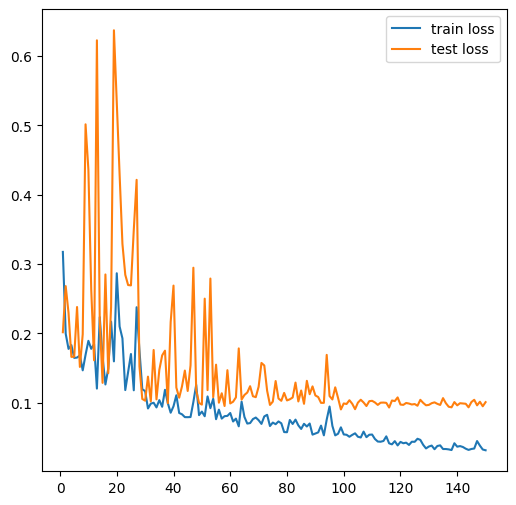

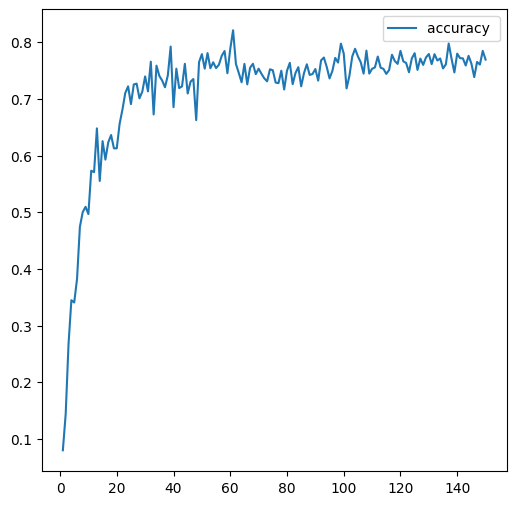

In [21]:

trainLoop(model, trainDataLoader, testDataLoader, optimizer, lossFn, steps, device, lrScheluder,scheluderStepsPerEpoch=1)

In [46]:
torch.cuda.empty_cache()
gc.collect()

0

In [47]:
torch.cuda.memory_allocated() / 8 / 1024/ 1024 , " mb"

(303.53863525390625, ' mb')

In [27]:
steps = 5 * 30

In [31]:
lrScheluder = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-8, 1e-4,step_size_up=2, step_size_down=14, mode="exp_range", gamma=(1-5/float(steps)))

  0%|          | 0/150 [00:00<?, ?it/s]

  Testing... 30/30, lr [1e-08], Avg Loss:0.8044377914790449, SRCC:0.07999801635742188, PLCC:0.09748890995979309, MAE:0.7858355641365051, COS:-0.8527145981788635				
  Testing... 8/8, Avg Loss:0.8591212204524449, SRCC:0.17130380868911743, PLCC:0.19736391305923462, MAE:0.7628985047340393, COS:-0.8445907831192017				


  1%|          | 1/150 [00:27<1:09:21, 27.93s/it]

  Testing... 30/30, lr [4.8338500000000005e-05], Avg Loss:1.4118805311877152, SRCC:-0.015073418617248535, PLCC:-0.027873240411281586, MAE:1.3978118896484375, COS:0.44336044788360596				
  Testing... 8/8, Avg Loss:0.23795518917696817, SRCC:0.059916019439697266, PLCC:0.10764604806900024, MAE:0.19866366684436798, COS:0.9312241077423096				


  1%|▏         | 2/150 [00:56<1:09:08, 28.03s/it]

  Testing... 30/30, lr [9.34451e-05], Avg Loss:0.34098452843468763, SRCC:0.05631387233734131, PLCC:0.06229144334793091, MAE:0.3230403959751129, COS:0.7577911019325256					
  Testing... 8/8, Avg Loss:0.6167958208492824, SRCC:0.4032409191131592, PLCC:0.4599911570549011, MAE:0.543993353843689, COS:0.9467344284057617				


  2%|▏         | 3/150 [01:23<1:08:02, 27.77s/it]

  Testing... 30/30, lr [8.387912547619047e-05], Avg Loss:0.3989439976626429, SRCC:0.10849666595458984, PLCC:0.1322227120399475, MAE:0.39127299189567566, COS:0.7640971541404724						
  Testing... 8/8, Avg Loss:1.2304318121501379, SRCC:0.5070070028305054, PLCC:0.561802327632904, MAE:1.0764601230621338, COS:0.9477101564407349						


  3%|▎         | 4/150 [01:51<1:08:15, 28.05s/it]

  Testing... 30/30, lr [7.484706580952382e-05], Avg Loss:0.3522695115414159, SRCC:0.24474948644638062, PLCC:0.2289365530014038, MAE:0.3477524220943451, COS:0.7784528136253357					
  Testing... 8/8, Avg Loss:0.9286314163889203, SRCC:0.5249930620193481, PLCC:0.5583248734474182, MAE:0.8113246560096741, COS:0.9500552415847778				


  3%|▎         | 5/150 [02:20<1:08:27, 28.33s/it]

  Testing... 30/30, lr [6.632395553677249e-05], Avg Loss:0.4911133513368409, SRCC:0.20959407091140747, PLCC:0.1893736571073532, MAE:0.4766533374786377, COS:0.7350730895996094						
  Testing... 8/8, Avg Loss:0.7831794704709735, SRCC:0.5786942839622498, PLCC:0.6539605259895325, MAE:0.6840838193893433, COS:0.9544651508331299				


  4%|▍         | 6/150 [02:49<1:08:23, 28.50s/it]

  Testing... 30/30, lr [5.828590032019402e-05], Avg Loss:0.2181348194336069, SRCC:0.3804437518119812, PLCC:0.39559727907180786, MAE:0.21158882975578308, COS:0.9095090627670288				
  Testing... 8/8, Avg Loss:0.4321106118815286, SRCC:0.5700337290763855, PLCC:0.6520547270774841, MAE:0.3807426989078522, COS:0.8576827049255371				


  5%|▍         | 7/150 [03:18<1:08:08, 28.59s/it]

  Testing... 30/30, lr [5.07100332785688e-05], Avg Loss:0.16700488688616916, SRCC:0.527092695236206, PLCC:0.5659192800521851, MAE:0.1656370311975479, COS:0.9383165836334229					
  Testing... 8/8, Avg Loss:0.26216896729809896, SRCC:0.5850390791893005, PLCC:0.6499515771865845, MAE:0.23260068893432617, COS:0.9514658451080322				


  5%|▌         | 8/150 [03:46<1:07:29, 28.52s/it]

  Testing... 30/30, lr [4.3574473039362814e-05], Avg Loss:0.19521225346573468, SRCC:0.449151873588562, PLCC:0.48931100964546204, MAE:0.19319194555282593, COS:0.9223833084106445				
  Testing... 8/8, Avg Loss:0.793848318713052, SRCC:0.6222199201583862, PLCC:0.6994235515594482, MAE:0.6933593153953552, COS:0.9583275318145752						


  6%|▌         | 9/150 [04:15<1:06:52, 28.46s/it]

  Testing... 30/30, lr [3.685828344579438e-05], Avg Loss:0.21259130203518375, SRCC:0.4490240812301636, PLCC:0.45929497480392456, MAE:0.20644554495811462, COS:0.912163496017456					
  Testing... 8/8, Avg Loss:0.18769756385258266, SRCC:0.5809615850448608, PLCC:0.6571353077888489, MAE:0.16298645734786987, COS:0.9599786996841431				


  7%|▋         | 10/150 [04:43<1:06:41, 28.58s/it]

  Testing... 30/30, lr [3.054143485508678e-05], Avg Loss:0.1543083206332963, SRCC:0.5777280330657959, PLCC:0.6194866299629211, MAE:0.1507832407951355, COS:0.9501243233680725					
  Testing... 8/8, Avg Loss:0.29715397528239657, SRCC:0.6764551997184753, PLCC:0.7330456972122192, MAE:0.2645528316497803, COS:0.9667037725448608				


  7%|▋         | 11/150 [05:12<1:06:13, 28.59s/it]

  Testing... 30/30, lr [2.4604766966597678e-05], Avg Loss:0.11111126274898134, SRCC:0.7312819361686707, PLCC:0.7645295858383179, MAE:0.10721301287412643, COS:0.9744560122489929				
  Testing... 8/8, Avg Loss:0.16353452844279154, SRCC:0.5837422013282776, PLCC:0.6778045892715454, MAE:0.1423301100730896, COS:0.9652855396270752					


  8%|▊         | 12/150 [05:40<1:05:33, 28.50s/it]

  Testing... 30/30, lr [1.902995312083554e-05], Avg Loss:0.11670080341141799, SRCC:0.704757034778595, PLCC:0.7487174272537231, MAE:0.11009124666452408, COS:0.9719354510307312					
  Testing... 8/8, Avg Loss:0.2614610471895763, SRCC:0.689547061920166, PLCC:0.7393580079078674, MAE:0.2281099110841751, COS:0.9681462645530701					


  9%|▊         | 13/150 [06:09<1:05:06, 28.52s/it]

  Testing... 30/30, lr [1.3799466012605764e-05], Avg Loss:0.12071886710051832, SRCC:0.7075210213661194, PLCC:0.7449326515197754, MAE:0.11194679886102676, COS:0.9719288349151611				
  Testing... 8/8, Avg Loss:0.2511052531855447, SRCC:0.6247490644454956, PLCC:0.6951199173927307, MAE:0.21463638544082642, COS:0.964962363243103				


  9%|▉         | 14/150 [06:38<1:04:47, 28.58s/it]

  Testing... 30/30, lr [8.89654476367927e-06], Avg Loss:0.11175888391404316, SRCC:0.7564940452575684, PLCC:0.7829081416130066, MAE:0.10013764351606369, COS:0.9761701822280884				
  Testing... 8/8, Avg Loss:0.13758982398680278, SRCC:0.6169261932373047, PLCC:0.721241295337677, MAE:0.1252058744430542, COS:0.9693449139595032						


 10%|█         | 15/150 [07:06<1:04:00, 28.45s/it]

  Testing... 30/30, lr [4.305163302444981e-06], Avg Loss:0.10388291575785341, SRCC:0.7943274974822998, PLCC:0.8130412101745605, MAE:0.0917690321803093, COS:0.9798398017883301					
  Testing... 8/8, Avg Loss:0.159050176186221, SRCC:0.5880283713340759, PLCC:0.6540777087211609, MAE:0.13534937798976898, COS:0.9633185863494873					


 11%|█         | 16/150 [07:34<1:03:29, 28.43s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.11027001615228324, SRCC:0.7788604497909546, PLCC:0.8124110698699951, MAE:0.1002727597951889, COS:0.9785443544387817					
  Testing... 8/8, Avg Loss:0.12733974946396692, SRCC:0.6862711906433105, PLCC:0.7329296469688416, MAE:0.11399202048778534, COS:0.9704487323760986				


 11%|█▏        | 17/150 [08:02<1:02:54, 28.38s/it]

  Testing... 30/30, lr [2.810514040165956e-05], Avg Loss:0.3544075273234269, SRCC:0.3219316601753235, PLCC:0.3307953178882599, MAE:0.3422465920448303, COS:0.8286046385765076						
  Testing... 8/8, Avg Loss:0.1610083899327687, SRCC:0.6572889089584351, PLCC:0.7301921844482422, MAE:0.14013420045375824, COS:0.9686096906661987					


 12%|█▏        | 18/150 [08:31<1:02:30, 28.41s/it]

  Testing... 30/30, lr [5.432727144320848e-05], Avg Loss:0.17438595459379, SRCC:0.541933000087738, PLCC:0.5952630043029785, MAE:0.1696890890598297, COS:0.941012978553772				92				
  Testing... 8/8, Avg Loss:0.41363200545310974, SRCC:0.6996514797210693, PLCC:0.7445513010025024, MAE:0.35824620723724365, COS:0.8987957239151001				


 13%|█▎        | 19/150 [08:59<1:02:06, 28.45s/it]

  Testing... 30/30, lr [4.876621746211809e-05], Avg Loss:0.13228650236951894, SRCC:0.657612681388855, PLCC:0.6758014559745789, MAE:0.13079211115837097, COS:0.9581444263458252					
  Testing... 8/8, Avg Loss:0.3245923753295626, SRCC:0.68296217918396, PLCC:0.7667210102081299, MAE:0.2891294062137604, COS:0.9696226119995117				


 13%|█▎        | 20/150 [09:28<1:01:41, 28.47s/it]

  Testing... 30/30, lr [4.35155478892746e-05], Avg Loss:0.1283214952925156, SRCC:0.6914225220680237, PLCC:0.7346974611282349, MAE:0.12165433168411255, COS:0.9679234027862549					
  Testing... 8/8, Avg Loss:0.6796327573912484, SRCC:0.6469103097915649, PLCC:0.7164177894592285, MAE:0.5909326672554016, COS:0.9600339531898499				


 14%|█▍        | 21/150 [09:57<1:01:17, 28.51s/it]

  Testing... 30/30, lr [3.856074937966277e-05], Avg Loss:0.18401785965623527, SRCC:0.5449398756027222, PLCC:0.5799387097358704, MAE:0.1801973581314087, COS:0.9350487589836121					
  Testing... 8/8, Avg Loss:0.13268778792449407, SRCC:0.6594547629356384, PLCC:0.728736937046051, MAE:0.11239952594041824, COS:0.9698840975761414					


 15%|█▍        | 22/150 [10:26<1:01:18, 28.74s/it]

  Testing... 30/30, lr [3.388793127303699e-05], Avg Loss:0.14796339001121192, SRCC:0.6691572666168213, PLCC:0.691673755645752, MAE:0.13788338005542755, COS:0.959867537021637						
  Testing... 8/8, Avg Loss:0.6764386551720756, SRCC:0.6778895854949951, PLCC:0.7522398829460144, MAE:0.5963305234909058, COS:0.9621722102165222				


 15%|█▌        | 23/150 [10:54<1:00:09, 28.42s/it]

  Testing... 30/30, lr [2.9483800207542178e-05], Avg Loss:0.20917042704491778, SRCC:0.5293319225311279, PLCC:0.555721640586853, MAE:0.20011334121227264, COS:0.9293964505195618				
  Testing... 8/8, Avg Loss:0.22261329420975276, SRCC:0.7172675728797913, PLCC:0.7784844636917114, MAE:0.19179926812648773, COS:0.9723461270332336				


 16%|█▌        | 24/150 [11:22<59:25, 28.30s/it]  

  Testing... 30/30, lr [2.5335635733888093e-05], Avg Loss:0.1065775472028502, SRCC:0.765671968460083, PLCC:0.8029032945632935, MAE:0.0992736890912056, COS:0.977260947227478								
  Testing... 8/8, Avg Loss:0.22617701121738978, SRCC:0.6928845047950745, PLCC:0.7476867437362671, MAE:0.2009328156709671, COS:0.9697193503379822				


 17%|█▋        | 25/150 [11:49<58:36, 28.13s/it]

  Testing... 30/30, lr [2.1431266891580348e-05], Avg Loss:0.10964043489817915, SRCC:0.7468197345733643, PLCC:0.7834214568138123, MAE:0.10622549802064896, COS:0.9754896759986877				
  Testing... 8/8, Avg Loss:0.3052810217653002, SRCC:0.7125744223594666, PLCC:0.7648483514785767, MAE:0.2654365599155426, COS:0.9689128398895264				


 17%|█▋        | 26/150 [12:17<58:09, 28.14s/it]

  Testing... 30/30, lr [1.7759049710166573e-05], Avg Loss:0.12139549414659369, SRCC:0.6964054703712463, PLCC:0.7339795827865601, MAE:0.12090332806110382, COS:0.9689043164253235				
  Testing... 8/8, Avg Loss:0.13449921991143907, SRCC:0.6968822479248047, PLCC:0.7624545693397522, MAE:0.11625125259160995, COS:0.9727692604064941				


 18%|█▊        | 27/150 [12:46<57:40, 28.13s/it]

  Testing... 30/30, lr [1.4307845599856406e-05], Avg Loss:0.08850788016771448, SRCC:0.8071658611297607, PLCC:0.8357459902763367, MAE:0.0875198096036911, COS:0.9820478558540344					
  Testing... 8/8, Avg Loss:0.21796717175415584, SRCC:0.7081953287124634, PLCC:0.7779675126075745, MAE:0.1903243213891983, COS:0.9716999530792236					


 19%|█▊        | 28/150 [13:13<57:00, 28.03s/it]

  Testing... 30/30, lr [1.1067000597222286e-05], Avg Loss:0.10742856947512462, SRCC:0.7708730101585388, PLCC:0.7950918674468994, MAE:0.10188575088977814, COS:0.9767918586730957				
  Testing... 8/8, Avg Loss:0.33932729065418243, SRCC:0.713651180267334, PLCC:0.7948051691055298, MAE:0.2927119731903076, COS:0.9717437028884888						


 19%|█▉        | 29/150 [13:41<56:34, 28.05s/it]

  Testing... 30/30, lr [8.026325432986158e-06], Avg Loss:0.10476623860926464, SRCC:0.7837169170379639, PLCC:0.8091398477554321, MAE:0.09822054952383041, COS:0.9787983894348145				
  Testing... 8/8, Avg Loss:0.16068884836775915, SRCC:0.7271462082862854, PLCC:0.7840521931648254, MAE:0.14371955394744873, COS:0.9737513065338135				


 20%|██        | 30/150 [14:10<56:30, 28.25s/it]

  Testing... 30/30, lr [5.1760763901466345e-06], Avg Loss:0.0906985603786748, SRCC:0.8370339274406433, PLCC:0.8580750226974487, MAE:0.0812072828412056, COS:0.9842996597290039						
  Testing... 8/8, Avg Loss:0.21161034064633505, SRCC:0.6951556205749512, PLCC:0.7445192933082581, MAE:0.18042217195034027, COS:0.9697584509849548				


 21%|██        | 31/150 [14:38<55:48, 28.14s/it]

  Testing... 30/30, lr [2.506936921904207e-06], Avg Loss:0.091487065086077, SRCC:0.8236278295516968, PLCC:0.851049542427063, MAE:0.08538144081830978, COS:0.9836745858192444						
  Testing... 8/8, Avg Loss:0.1340669191309384, SRCC:0.7183613777160645, PLCC:0.7751253843307495, MAE:0.11634998768568039, COS:0.9742292761802673					


 21%|██▏       | 32/150 [15:06<55:07, 28.03s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.08595045013674374, SRCC:0.8611270189285278, PLCC:0.8810401558876038, MAE:0.07781951874494553, COS:0.9864828586578369				
  Testing... 8/8, Avg Loss:0.13112294035298483, SRCC:0.7165275812149048, PLCC:0.7587233781814575, MAE:0.12005436420440674, COS:0.9729059338569641				


 22%|██▏       | 33/150 [15:34<54:45, 28.08s/it]

  Testing... 30/30, lr [1.6342741843611186e-05], Avg Loss:0.13947029013572068, SRCC:0.6785414218902588, PLCC:0.7130122184753418, MAE:0.13323518633842468, COS:0.9633890390396118				
  Testing... 8/8, Avg Loss:0.1913572038922991, SRCC:0.6767350435256958, PLCC:0.7482406497001648, MAE:0.16363151371479034, COS:0.9706969261169434				


 23%|██▎       | 34/150 [16:02<54:09, 28.01s/it]

  Testing... 30/30, lr [3.158663423098162e-05], Avg Loss:0.143813568199503, SRCC:0.6896387338638306, PLCC:0.7249150276184082, MAE:0.12968693673610687, COS:0.9646324515342712					
  Testing... 8/8, Avg Loss:0.11437450189675603, SRCC:0.7054033279418945, PLCC:0.7624723315238953, MAE:0.10484122484922409, COS:0.9729567170143127				


 23%|██▎       | 35/150 [16:30<53:54, 28.13s/it]

  Testing... 30/30, lr [2.8353788345428747e-05], Avg Loss:0.10310745008032897, SRCC:0.7888089418411255, PLCC:0.8153237104415894, MAE:0.09680259227752686, COS:0.9793160557746887				
  Testing... 8/8, Avg Loss:0.21236678745065415, SRCC:0.7204532623291016, PLCC:0.7736890912055969, MAE:0.18256895244121552, COS:0.9716187715530396				


 24%|██▍       | 36/150 [16:59<53:31, 28.17s/it]

  Testing... 30/30, lr [2.5301380369767188e-05], Avg Loss:0.11486301237139208, SRCC:0.7195055484771729, PLCC:0.759349524974823, MAE:0.1131928488612175, COS:0.971509575843811							
  Testing... 8/8, Avg Loss:0.493004104920796, SRCC:0.706580638885498, PLCC:0.7706036567687988, MAE:0.42972907423973083, COS:0.9666962623596191				


 25%|██▍       | 37/150 [17:27<53:11, 28.25s/it]

  Testing... 30/30, lr [2.2420973160988146e-05], Avg Loss:0.1765291801300542, SRCC:0.5919481515884399, PLCC:0.628847599029541, MAE:0.16685934364795685, COS:0.9468973875045776				
  Testing... 8/8, Avg Loss:0.14954566104071482, SRCC:0.7386993169784546, PLCC:0.7896597385406494, MAE:0.12458477914333344, COS:0.9745421409606934				


 25%|██▌       | 38/150 [17:55<52:28, 28.11s/it]

  Testing... 30/30, lr [1.970449156571686e-05], Avg Loss:0.11570045917198576, SRCC:0.7468063831329346, PLCC:0.7863225340843201, MAE:0.10593118518590927, COS:0.9756259918212891				
  Testing... 8/8, Avg Loss:0.2447463401726314, SRCC:0.7107169032096863, PLCC:0.7645126581192017, MAE:0.21346913278102875, COS:0.970802366733551						


 26%|██▌       | 39/150 [18:23<51:57, 28.09s/it]

  Testing... 30/30, lr [1.7144207662173668e-05], Avg Loss:0.0998565048493188, SRCC:0.8044025897979736, PLCC:0.8238312005996704, MAE:0.09408710896968842, COS:0.9801226854324341				
  Testing... 8/8, Avg Loss:0.4149275507245745, SRCC:0.7011731863021851, PLCC:0.7730258703231812, MAE:0.3645263612270355, COS:0.9680579304695129						


 27%|██▋       | 40/150 [18:51<51:35, 28.14s/it]

  Testing... 30/30, lr [1.4732726583793667e-05], Avg Loss:0.11164049868439806, SRCC:0.7499337196350098, PLCC:0.7622647881507874, MAE:0.11028188467025757, COS:0.9718343019485474				
  Testing... 8/8, Avg Loss:0.130771846643516, SRCC:0.73324054479599, PLCC:0.7833614945411682, MAE:0.11416056007146835, COS:0.9744412302970886								


 27%|██▋       | 41/150 [19:19<51:11, 28.18s/it]

  Testing... 30/30, lr [1.2462972902125477e-05], Avg Loss:0.0841355118258246, SRCC:0.8598978519439697, PLCC:0.871170699596405, MAE:0.07727865129709244, COS:0.9857733249664307						
  Testing... 8/8, Avg Loss:0.11346577214343208, SRCC:0.7705883383750916, PLCC:0.8095333576202393, MAE:0.09951872378587723, COS:0.9775583148002625				


 28%|██▊       | 42/150 [19:47<50:38, 28.13s/it]

  Testing... 30/30, lr [1.0328177547475396e-05], Avg Loss:0.09337360180657485, SRCC:0.8328195810317993, PLCC:0.8591381907463074, MAE:0.08258017897605896, COS:0.9844182133674622				
  Testing... 8/8, Avg Loss:0.19839319373880113, SRCC:0.69163978099823, PLCC:0.7767270803451538, MAE:0.1748158037662506, COS:0.9716036915779114						


 29%|██▊       | 43/150 [20:15<50:03, 28.07s/it]

  Testing... 30/30, lr [8.321865246577403e-06], Avg Loss:0.08713743142012892, SRCC:0.8344569802284241, PLCC:0.8546704649925232, MAE:0.08306032419204712, COS:0.9840731024742126				
  Testing... 8/8, Avg Loss:0.17995383696896688, SRCC:0.7106049656867981, PLCC:0.7488853335380554, MAE:0.15585888922214508, COS:0.9715785980224609				


 29%|██▉       | 44/150 [20:44<49:44, 28.15s/it]

  Testing... 30/30, lr [6.437842457353191e-06], Avg Loss:0.0925181785534168, SRCC:0.8564624786376953, PLCC:0.8702895641326904, MAE:0.07831889390945435, COS:0.9856431484222412					
  Testing... 8/8, Avg Loss:0.1551656233412879, SRCC:0.6691247224807739, PLCC:0.7439541220664978, MAE:0.12996183335781097, COS:0.9709136486053467				


 30%|███       | 45/150 [21:12<49:10, 28.10s/it]

  Testing... 30/30, lr [4.6701857815810635e-06], Avg Loss:0.06962461525510097, SRCC:0.8745920062065125, PLCC:0.8988531827926636, MAE:0.0689193606376648, COS:0.9887528419494629					
  Testing... 8/8, Avg Loss:0.11485798444066729, SRCC:0.728145182132721, PLCC:0.7907177805900574, MAE:0.1014115959405899, COS:0.9761251211166382				


 31%|███       | 46/150 [21:39<48:31, 27.99s/it]

  Testing... 30/30, lr [3.0132308370189072e-06], Avg Loss:0.09578858405865472, SRCC:0.8126312494277954, PLCC:0.8339099884033203, MAE:0.08880206197500229, COS:0.9815711975097656				
  Testing... 8/8, Avg Loss:0.20099045016935893, SRCC:0.7537966370582581, PLCC:0.7922656536102295, MAE:0.18136249482631683, COS:0.9731557965278625				


 31%|███▏      | 47/150 [22:07<48:05, 28.01s/it]

  Testing... 30/30, lr [1.4615615712258052e-06], Avg Loss:0.08431180271095243, SRCC:0.8676852583885193, PLCC:0.8802065849304199, MAE:0.07395190745592117, COS:0.9867549538612366				
  Testing... 8/8, Avg Loss:0.16167564477239335, SRCC:0.7393823266029358, PLCC:0.7718611359596252, MAE:0.14184339344501495, COS:0.9730592370033264				


 32%|███▏      | 48/150 [22:36<47:40, 28.05s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.07434280717681194, SRCC:0.892217755317688, PLCC:0.9027256965637207, MAE:0.06653260439634323, COS:0.989161491394043						
  Testing... 8/8, Avg Loss:0.1681126994746072, SRCC:0.719132661819458, PLCC:0.7834580540657043, MAE:0.14566625654697418, COS:0.9727614521980286				


 33%|███▎      | 49/150 [23:04<47:11, 28.04s/it]

  Testing... 30/30, lr [9.504825522007018e-06], Avg Loss:0.10072920869650512, SRCC:0.7755503058433533, PLCC:0.8032901287078857, MAE:0.09984362870454788, COS:0.9776736497879028				
  Testing... 8/8, Avg Loss:0.13335825609309332, SRCC:0.7449586987495422, PLCC:0.7923839092254639, MAE:0.11360467970371246, COS:0.9749630093574524				


 33%|███▎      | 50/150 [23:31<46:38, 27.99s/it]

  Testing... 30/30, lr [1.8366662675880234e-05], Avg Loss:0.09022794085843809, SRCC:0.8388006687164307, PLCC:0.8584420084953308, MAE:0.08286485075950623, COS:0.9843267202377319				
  Testing... 8/8, Avg Loss:0.16785529468740737, SRCC:0.743790864944458, PLCC:0.7824495434761047, MAE:0.14703820645809174, COS:0.9740317463874817					


 34%|███▍      | 51/150 [23:59<46:06, 27.94s/it]

  Testing... 30/30, lr [1.6487290068587737e-05], Avg Loss:0.13279098375090237, SRCC:0.72723788022995, PLCC:0.7594071626663208, MAE:0.1209341436624527, COS:0.9684635400772095							
  Testing... 8/8, Avg Loss:0.16342661316905702, SRCC:0.7294609546661377, PLCC:0.7895283699035645, MAE:0.1403876692056656, COS:0.9743508696556091				


 35%|███▍      | 52/150 [24:27<45:32, 27.88s/it]

  Testing... 30/30, lr [1.471281267658598e-05], Avg Loss:0.08858942073480837, SRCC:0.8255840539932251, PLCC:0.8525258302688599, MAE:0.08558936417102814, COS:0.9830124378204346				
  Testing... 8/8, Avg Loss:0.3808586469718388, SRCC:0.7195168733596802, PLCC:0.7744808197021484, MAE:0.3346533179283142, COS:0.9693170189857483				


 35%|███▌      | 53/150 [24:55<44:56, 27.80s/it]

  Testing... 30/30, lr [1.3038325677308131e-05], Avg Loss:0.12468193638427504, SRCC:0.762204647064209, PLCC:0.7837626934051514, MAE:0.11240052431821823, COS:0.9740691781044006					
  Testing... 8/8, Avg Loss:0.12557306779282434, SRCC:0.7398139834403992, PLCC:0.7773664593696594, MAE:0.11276108771562576, COS:0.9735738039016724				


 36%|███▌      | 54/150 [25:23<44:48, 28.01s/it]

  Testing... 30/30, lr [1.1459134686119267e-05], Avg Loss:0.09189129813477911, SRCC:0.8156206607818604, PLCC:0.8457607626914978, MAE:0.08632179349660873, COS:0.98256516456604						
  Testing... 8/8, Avg Loss:0.12343191994088036, SRCC:0.7042042016983032, PLCC:0.7852187752723694, MAE:0.10918942093849182, COS:0.9748407602310181				


 37%|███▋      | 55/150 [25:51<44:06, 27.86s/it]

  Testing... 30/30, lr [9.970747176923764e-06], Avg Loss:0.07837574774849004, SRCC:0.8731304407119751, PLCC:0.8830904960632324, MAE:0.07291053235530853, COS:0.9870303869247437				
  Testing... 8/8, Avg Loss:0.14617429780108587, SRCC:0.7416629791259766, PLCC:0.7893107533454895, MAE:0.1250292956829071, COS:0.9752720594406128				


 37%|███▋      | 56/150 [26:18<43:31, 27.78s/it]

  Testing... 30/30, lr [8.568864240912269e-06], Avg Loss:0.0799051561746104, SRCC:0.872685968875885, PLCC:0.8892514705657959, MAE:0.07185910642147064, COS:0.9874997138977051						
  Testing... 8/8, Avg Loss:0.11793864624840873, SRCC:0.7145657539367676, PLCC:0.7731755375862122, MAE:0.10391350090503693, COS:0.974331796169281					


 38%|███▊      | 57/150 [26:47<43:23, 28.00s/it]

  Testing... 30/30, lr [7.249372670438294e-06], Avg Loss:0.08255673392579474, SRCC:0.8581111431121826, PLCC:0.875422477722168, MAE:0.07691100984811783, COS:0.985942542552948					
  Testing... 8/8, Avg Loss:0.1750160785658019, SRCC:0.7038123607635498, PLCC:0.7633466720581055, MAE:0.15320663154125214, COS:0.9719369411468506					


 39%|███▊      | 58/150 [27:15<43:01, 28.06s/it]

  Testing... 30/30, lr [6.008337355506016e-06], Avg Loss:0.08303180568177125, SRCC:0.8678296804428101, PLCC:0.8883466124534607, MAE:0.0715937539935112, COS:0.9875056147575378				
  Testing... 8/8, Avg Loss:0.18546503356524877, SRCC:0.7219341397285461, PLCC:0.7740406394004822, MAE:0.1611616611480713, COS:0.9716320633888245				


 39%|███▉      | 59/150 [27:44<42:58, 28.34s/it]

  Testing... 30/30, lr [4.841993980824291e-06], Avg Loss:0.08993284519890259, SRCC:0.8697358965873718, PLCC:0.8822308778762817, MAE:0.07353729754686356, COS:0.9869771003723145				
  Testing... 8/8, Avg Loss:0.1566257764186178, SRCC:0.7290843725204468, PLCC:0.7881659269332886, MAE:0.13657629489898682, COS:0.9737533330917358				


 40%|████      | 60/150 [28:12<42:32, 28.36s/it]

  Testing... 30/30, lr [3.7467420118374514e-06], Avg Loss:0.07682721933414197, SRCC:0.862606406211853, PLCC:0.8795873522758484, MAE:0.07642363011837006, COS:0.9865185022354126					
  Testing... 8/8, Avg Loss:0.2068129309586116, SRCC:0.7197474241256714, PLCC:0.7544432282447815, MAE:0.1794317662715912, COS:0.9709646701812744						


 41%|████      | 61/150 [28:41<42:00, 28.32s/it]

  Testing... 30/30, lr [2.7191379585821524e-06], Avg Loss:0.07858698917873974, SRCC:0.8728482723236084, PLCC:0.8927710652351379, MAE:0.06938041746616364, COS:0.9880526661872864				
  Testing... 8/8, Avg Loss:0.13914774464709417, SRCC:0.7088518142700195, PLCC:0.772163450717926, MAE:0.1229790672659874, COS:0.9728861451148987						


 41%|████▏     | 62/150 [29:09<41:43, 28.45s/it]

  Testing... 30/30, lr [1.7558889066418316e-06], Avg Loss:0.06595421055781431, SRCC:0.8939005732536316, PLCC:0.9108561277389526, MAE:0.06523267179727554, COS:0.9899921417236328				
  Testing... 8/8, Avg Loss:0.1528371274471283, SRCC:0.7103184461593628, PLCC:0.752647876739502, MAE:0.12912331521511078, COS:0.9713153839111328						


 42%|████▏     | 63/150 [29:37<41:08, 28.37s/it]

  Testing... 30/30, lr [8.538463048768853e-07], Avg Loss:0.08056621870090222, SRCC:0.8856494426727295, PLCC:0.8980353474617004, MAE:0.06779681146144867, COS:0.9886660575866699				
  Testing... 8/8, Avg Loss:0.1721168394599642, SRCC:0.7226532697677612, PLCC:0.7592608332633972, MAE:0.15157148241996765, COS:0.9720004796981812				


 43%|████▎     | 64/150 [30:06<40:41, 28.39s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.07404478459522643, SRCC:0.8943160176277161, PLCC:0.9042052626609802, MAE:0.06727426499128342, COS:0.989319920539856					
  Testing... 8/8, Avg Loss:0.15504846615450724, SRCC:0.7232869863510132, PLCC:0.7708761692047119, MAE:0.136005237698555, COS:0.9722313284873962					


 43%|████▎     | 65/150 [30:34<40:12, 28.38s/it]

  Testing... 30/30, lr [5.529692440900248e-06], Avg Loss:0.0753903897671864, SRCC:0.8782186508178711, PLCC:0.898883044719696, MAE:0.0690281018614769, COS:0.9885299205780029						
  Testing... 8/8, Avg Loss:0.21716099125998362, SRCC:0.7479944825172424, PLCC:0.7836734056472778, MAE:0.19187259674072266, COS:0.9727821350097656				


 44%|████▍     | 66/150 [31:02<39:40, 28.33s/it]

  Testing... 30/30, lr [1.068140538574048e-05], Avg Loss:0.08496364141846525, SRCC:0.8533703684806824, PLCC:0.8693693280220032, MAE:0.07977081090211868, COS:0.985564649105072				
  Testing... 8/8, Avg Loss:0.11766712261097771, SRCC:0.7382505536079407, PLCC:0.7874366641044617, MAE:0.10333336144685745, COS:0.9757471084594727				


 45%|████▍     | 67/150 [31:31<39:05, 28.26s/it]

  Testing... 30/30, lr [9.588856739105146e-06], Avg Loss:0.0865039501724572, SRCC:0.8290244340896606, PLCC:0.852334201335907, MAE:0.08441150933504105, COS:0.983338475227356							
  Testing... 8/8, Avg Loss:0.22815880605152675, SRCC:0.7190150022506714, PLCC:0.784305214881897, MAE:0.20139935612678528, COS:0.972951352596283				


 45%|████▌     | 68/150 [31:59<38:36, 28.25s/it]

  Testing... 30/30, lr [8.5572875518169e-06], Avg Loss:0.07830312372795467, SRCC:0.8719224333763123, PLCC:0.8936247229576111, MAE:0.07184114307165146, COS:0.9880343079566956				
  Testing... 8/8, Avg Loss:0.139348138655935, SRCC:0.7416136264801025, PLCC:0.7849936485290527, MAE:0.12006134539842606, COS:0.9747658371925354						


 46%|████▌     | 69/150 [32:28<38:19, 28.39s/it]

  Testing... 30/30, lr [7.583846469526642e-06], Avg Loss:0.08633225912163997, SRCC:0.8627703189849854, PLCC:0.8831156492233276, MAE:0.07583465427160263, COS:0.986919641494751					
  Testing... 8/8, Avg Loss:0.13155983281987055, SRCC:0.7340877056121826, PLCC:0.7786593437194824, MAE:0.11980461329221725, COS:0.9736700654029846				


 47%|████▋     | 70/150 [32:56<37:47, 28.34s/it]

  Testing... 30/30, lr [6.665804473220382e-06], Avg Loss:0.07500797214693036, SRCC:0.888441801071167, PLCC:0.8975504636764526, MAE:0.06948009878396988, COS:0.9885777235031128					
  Testing... 8/8, Avg Loss:0.1960823450769697, SRCC:0.7629381418228149, PLCC:0.80524080991745, MAE:0.17240376770496368, COS:0.9756458401679993							


 47%|████▋     | 71/150 [33:24<37:17, 28.32s/it]

  Testing... 30/30, lr [5.800549891701733e-06], Avg Loss:0.07565392553806305, SRCC:0.8649017810821533, PLCC:0.8857381939888, MAE:0.07121643424034119, COS:0.987359881401062							
  Testing... 8/8, Avg Loss:0.17143844387360982, SRCC:0.7576037049293518, PLCC:0.8046295642852783, MAE:0.14757275581359863, COS:0.9743316173553467				


 48%|████▊     | 72/150 [33:52<36:51, 28.36s/it]

  Testing... 30/30, lr [4.985583610647414e-06], Avg Loss:0.07591167015248332, SRCC:0.8931562900543213, PLCC:0.9116842150688171, MAE:0.06224614009261131, COS:0.9900040626525879					
  Testing... 8/8, Avg Loss:0.164745426603726, SRCC:0.7080406546592712, PLCC:0.7691546678543091, MAE:0.14085286855697632, COS:0.9723289608955383				


 49%|████▊     | 73/150 [34:21<36:34, 28.50s/it]

  Testing... 30/30, lr [4.218514470672605e-06], Avg Loss:0.06987813795948851, SRCC:0.8881309032440186, PLCC:0.9004901051521301, MAE:0.06865959614515305, COS:0.9889248609542847				
  Testing... 8/8, Avg Loss:0.18173859481300628, SRCC:0.7517009973526001, PLCC:0.7858151197433472, MAE:0.15479981899261475, COS:0.9726121425628662				


 49%|████▉     | 74/150 [34:50<36:20, 28.69s/it]

  Testing... 30/30, lr [3.4970548471287293e-06], Avg Loss:0.08369838330766251, SRCC:0.8526971340179443, PLCC:0.8703885078430176, MAE:0.07707460224628448, COS:0.9856302738189697				
  Testing... 8/8, Avg Loss:0.17920126020908356, SRCC:0.7489118576049805, PLCC:0.8024076819419861, MAE:0.15752039849758148, COS:0.9746034145355225				


 50%|█████     | 75/150 [35:19<36:00, 28.80s/it]

  Testing... 30/30, lr [2.819016404631477e-06], Avg Loss:0.07264355480157096, SRCC:0.8894102573394775, PLCC:0.9066392779350281, MAE:0.06591258198022842, COS:0.9895479679107666				
  Testing... 8/8, Avg Loss:0.19424197929246084, SRCC:0.7335716485977173, PLCC:0.7803254127502441, MAE:0.17435786128044128, COS:0.9735614061355591				


 51%|█████     | 76/150 [35:48<35:27, 28.75s/it]

  Testing... 30/30, lr [2.182306019581675e-06], Avg Loss:0.07372465973784184, SRCC:0.8854694366455078, PLCC:0.9034309387207031, MAE:0.06815224885940552, COS:0.9891928434371948				
  Testing... 8/8, Avg Loss:0.16976691356727056, SRCC:0.7371093034744263, PLCC:0.7858262062072754, MAE:0.14636310935020447, COS:0.9738625884056091				


 51%|█████▏    | 77/150 [36:17<34:59, 28.76s/it]

  Testing... 30/30, lr [1.5849218641967145e-06], Avg Loss:0.07632137693721673, SRCC:0.8990398645401001, PLCC:0.9119971990585327, MAE:0.06500015407800674, COS:0.9901531338691711				
  Testing... 8/8, Avg Loss:0.11561961046286992, SRCC:0.7633432149887085, PLCC:0.80665123462677, MAE:0.10166271030902863, COS:0.9766724705696106						


 52%|█████▏    | 78/150 [36:46<34:37, 28.85s/it]

  Testing... 30/30, lr [1.0249496458156604e-06], Avg Loss:0.06533975359694712, SRCC:0.8975762724876404, PLCC:0.9123995304107666, MAE:0.06364498287439346, COS:0.9900729060173035				
  Testing... 8/8, Avg Loss:0.15982036931174143, SRCC:0.7313441038131714, PLCC:0.7870309352874756, MAE:0.13515134155750275, COS:0.9739028811454773				


 53%|█████▎    | 79/150 [37:15<34:10, 28.87s/it]

  Testing... 30/30, lr [5.005589954775693e-07], Avg Loss:0.073544066913169, SRCC:0.8907760977745056, PLCC:0.9094707369804382, MAE:0.06493797153234482, COS:0.9898762702941895						
  Testing... 8/8, Avg Loss:0.1345661303826741, SRCC:0.7208697199821472, PLCC:0.7697221040725708, MAE:0.11920632421970367, COS:0.9734858274459839					


 53%|█████▎    | 80/150 [37:44<33:44, 28.92s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.0695929285781137, SRCC:0.8973928093910217, PLCC:0.9081069827079773, MAE:0.06513151526451111, COS:0.9896591901779175					
  Testing... 8/8, Avg Loss:0.13614762840526445, SRCC:0.7054555416107178, PLCC:0.7604042291641235, MAE:0.12627623975276947, COS:0.9721003174781799				


 54%|█████▍    | 81/150 [38:13<33:09, 28.83s/it]

  Testing... 30/30, lr [3.2188008959738337e-06], Avg Loss:0.07586718761715396, SRCC:0.8844723105430603, PLCC:0.89448082447052, MAE:0.0704021155834198, COS:0.9881391525268555							
  Testing... 8/8, Avg Loss:0.23245755902358464, SRCC:0.7205244302749634, PLCC:0.7810620069503784, MAE:0.19880154728889465, COS:0.9719313383102417				


 55%|█████▍    | 82/150 [38:41<32:39, 28.82s/it]

  Testing... 30/30, lr [6.213681732216078e-06], Avg Loss:0.08759167507804673, SRCC:0.8477063775062561, PLCC:0.8676996827125549, MAE:0.07967158406972885, COS:0.9852645993232727				
  Testing... 8/8, Avg Loss:0.15260409457342966, SRCC:0.731575608253479, PLCC:0.7769620418548584, MAE:0.1332533210515976, COS:0.9733221530914307						


 55%|█████▌    | 83/150 [39:11<32:21, 28.98s/it]

  Testing... 30/30, lr [5.57854288820348e-06], Avg Loss:0.06660418597788646, SRCC:0.8941287398338318, PLCC:0.9083835482597351, MAE:0.06465495377779007, COS:0.9897445440292358				
  Testing... 8/8, Avg Loss:0.19325088390282222, SRCC:0.7313649654388428, PLCC:0.776603102684021, MAE:0.1686185896396637, COS:0.9732679724693298				


 56%|█████▌    | 84/150 [39:40<31:56, 29.04s/it]

  Testing... 30/30, lr [4.978853654089259e-06], Avg Loss:0.08575736628524189, SRCC:0.8729467391967773, PLCC:0.886630654335022, MAE:0.07188662141561508, COS:0.9873431921005249					
  Testing... 8/8, Avg Loss:0.11702724971941539, SRCC:0.7196800708770752, PLCC:0.7752190232276917, MAE:0.10298541933298111, COS:0.9745603799819946				


 57%|█████▋    | 85/150 [40:08<31:05, 28.70s/it]

  Testing... 30/30, lr [4.412956432373538e-06], Avg Loss:0.07872528505736384, SRCC:0.8856317400932312, PLCC:0.8976684212684631, MAE:0.07034910470247269, COS:0.9884378910064697				
  Testing... 8/8, Avg Loss:0.19133935230118887, SRCC:0.7588844299316406, PLCC:0.8093999028205872, MAE:0.16440074145793915, COS:0.9750442504882812				


 57%|█████▋    | 86/150 [40:36<30:19, 28.42s/it]

  Testing... 30/30, lr [3.8792647436009885e-06], Avg Loss:0.07112304737855649, SRCC:0.895466685295105, PLCC:0.9066566228866577, MAE:0.06699223816394806, COS:0.9895792603492737				
  Testing... 8/8, Avg Loss:0.14655349935804093, SRCC:0.7009321451187134, PLCC:0.7599499821662903, MAE:0.13161197304725647, COS:0.9724926352500916				


 58%|█████▊    | 87/150 [41:04<29:42, 28.29s/it]

  Testing... 30/30, lr [3.3762603269328595e-06], Avg Loss:0.06908762133840857, SRCC:0.9024741053581238, PLCC:0.9139750003814697, MAE:0.06300073117017746, COS:0.9903550744056702				
  Testing... 8/8, Avg Loss:0.15931525507143565, SRCC:0.7081554532051086, PLCC:0.7764767408370972, MAE:0.1448022574186325, COS:0.9728744626045227					


 59%|█████▊    | 88/150 [41:32<29:14, 28.30s/it]

  Testing... 30/30, lr [2.9024903549941606e-06], Avg Loss:0.06896010490840879, SRCC:0.8850318789482117, PLCC:0.8993086218833923, MAE:0.06729960441589355, COS:0.9887675046920776					
  Testing... 8/8, Avg Loss:0.15127642452716827, SRCC:0.7355335354804993, PLCC:0.7988325357437134, MAE:0.12888583540916443, COS:0.974186360836029				


 59%|█████▉    | 89/150 [42:00<28:44, 28.28s/it]

  Testing... 30/30, lr [2.4565647585992277e-06], Avg Loss:0.0701354007268774, SRCC:0.8952000141143799, PLCC:0.911304235458374, MAE:0.0647963434457779, COS:0.9900791645050049						
  Testing... 8/8, Avg Loss:0.14833679688828333, SRCC:0.6914017200469971, PLCC:0.752983033657074, MAE:0.13357317447662354, COS:0.9715750217437744				


 60%|██████    | 90/150 [42:28<28:06, 28.11s/it]

  Testing... 30/30, lr [2.0371536571250742e-06], Avg Loss:0.06949992606352115, SRCC:0.8928337693214417, PLCC:0.9090119004249573, MAE:0.06631521135568619, COS:0.9898329377174377					
  Testing... 8/8, Avg Loss:0.15124431358916418, SRCC:0.7639930844306946, PLCC:0.810036301612854, MAE:0.12415456771850586, COS:0.9767857789993286					


 61%|██████    | 91/150 [42:55<27:30, 27.98s/it]

  Testing... 30/30, lr [1.6429848904618653e-06], Avg Loss:0.07130804259715409, SRCC:0.9009589552879333, PLCC:0.9147289395332336, MAE:0.06046206131577492, COS:0.9904256463050842					
  Testing... 8/8, Avg Loss:0.16023993917873927, SRCC:0.7383795976638794, PLCC:0.7997750639915466, MAE:0.13607537746429443, COS:0.9736530780792236				


 61%|██████▏   | 92/150 [43:24<27:04, 28.01s/it]

  Testing... 30/30, lr [1.2728416486238425e-06], Avg Loss:0.07100368252602117, SRCC:0.8962149620056152, PLCC:0.9113177061080933, MAE:0.0647360309958458, COS:0.9900798797607422					
  Testing... 8/8, Avg Loss:0.15474958717823029, SRCC:0.7327946424484253, PLCC:0.7819252610206604, MAE:0.13333484530448914, COS:0.973250687122345				


 62%|██████▏   | 93/150 [43:52<26:36, 28.02s/it]

  Testing... 30/30, lr [9.255601952522859e-07], Avg Loss:0.06488976152292614, SRCC:0.9026631116867065, PLCC:0.9160402417182922, MAE:0.06281890720129013, COS:0.9905866384506226				
  Testing... 8/8, Avg Loss:0.1477570938212531, SRCC:0.7207406759262085, PLCC:0.7801212668418884, MAE:0.12726393342018127, COS:0.9738790392875671				


 63%|██████▎   | 94/150 [44:21<26:32, 28.43s/it]

  Testing... 30/30, lr [6.000276813848064e-07], Avg Loss:0.0673727769533108, SRCC:0.8889740705490112, PLCC:0.9021373987197876, MAE:0.06694859266281128, COS:0.9890733361244202					
  Testing... 8/8, Avg Loss:0.14547405072620936, SRCC:0.7398965358734131, PLCC:0.7929439544677734, MAE:0.12965047359466553, COS:0.9750502109527588				


 63%|██████▎   | 95/150 [44:50<26:21, 28.75s/it]

  Testing... 30/30, lr [2.951800460026565e-07], Avg Loss:0.06978410045648444, SRCC:0.897576630115509, PLCC:0.9116575121879578, MAE:0.06401984393596649, COS:0.9900684356689453				
  Testing... 8/8, Avg Loss:0.1643187158874103, SRCC:0.7249983549118042, PLCC:0.7856181859970093, MAE:0.13944989442825317, COS:0.97318035364151							


 64%|██████▍   | 96/150 [45:20<26:09, 29.06s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.062254037579585766, SRCC:0.915303111076355, PLCC:0.9239282011985779, MAE:0.060009170323610306, COS:0.9914411902427673				
  Testing... 8/8, Avg Loss:0.14383727312088013, SRCC:0.7290359735488892, PLCC:0.7757949829101562, MAE:0.1282464563846588, COS:0.9740643501281738				


 65%|██████▍   | 97/150 [45:48<25:23, 28.74s/it]

  Testing... 30/30, lr [1.8753943675751539e-06], Avg Loss:0.0773528470047589, SRCC:0.8990046977996826, PLCC:0.9120475053787231, MAE:0.064415842294693, COS:0.9901399612426758							
  Testing... 8/8, Avg Loss:0.1623096540570259, SRCC:0.7037943601608276, PLCC:0.7524056434631348, MAE:0.14240646362304688, COS:0.971287190914154					


 65%|██████▌   | 98/150 [46:16<24:46, 28.58s/it]

  Testing... 30/30, lr [3.6164291106452982e-06], Avg Loss:0.06650039605025587, SRCC:0.8963361382484436, PLCC:0.9067487120628357, MAE:0.0656510591506958, COS:0.9895913600921631				
  Testing... 8/8, Avg Loss:0.18979021055357798, SRCC:0.7213705778121948, PLCC:0.7651747465133667, MAE:0.16899599134922028, COS:0.9721760749816895				


 66%|██████▌   | 99/150 [46:45<24:17, 28.57s/it]

  Testing... 30/30, lr [3.247199463603041e-06], Avg Loss:0.07020614578806121, SRCC:0.8860542178153992, PLCC:0.9027461409568787, MAE:0.06872466206550598, COS:0.9891181588172913				
  Testing... 8/8, Avg Loss:0.20413655042648315, SRCC:0.7465866208076477, PLCC:0.8033887147903442, MAE:0.18112307786941528, COS:0.9738247394561768				


 67%|██████▋   | 100/150 [47:13<23:43, 28.47s/it]

  Testing... 30/30, lr [2.8985779829073295e-06], Avg Loss:0.07712450443670668, SRCC:0.8879412412643433, PLCC:0.8973492980003357, MAE:0.06920308619737625, COS:0.9885112047195435				
  Testing... 8/8, Avg Loss:0.20014399502958571, SRCC:0.7445108890533447, PLCC:0.7991421222686768, MAE:0.17704637348651886, COS:0.9750497937202454				


 67%|██████▋   | 101/150 [47:41<23:08, 28.35s/it]

  Testing... 30/30, lr [2.5696010459651053e-06], Avg Loss:0.0701578729625406, SRCC:0.8844542503356934, PLCC:0.8994362950325012, MAE:0.06916536390781403, COS:0.9887799024581909					
  Testing... 8/8, Avg Loss:0.1461346713559968, SRCC:0.7476130723953247, PLCC:0.8152381777763367, MAE:0.12396971136331558, COS:0.977466344833374					


 68%|██████▊   | 102/150 [48:09<22:34, 28.21s/it]

  Testing... 30/30, lr [2.259346373726911e-06], Avg Loss:0.07523013612833516, SRCC:0.8958271741867065, PLCC:0.907107949256897, MAE:0.06527498364448547, COS:0.9896233081817627				
  Testing... 8/8, Avg Loss:0.1393601426056453, SRCC:0.7518461346626282, PLCC:0.7994465827941895, MAE:0.1241074949502945, COS:0.9750621914863586				


 69%|██████▊   | 103/150 [48:37<22:01, 28.11s/it]

  Testing... 30/30, lr [1.9669313451424128e-06], Avg Loss:0.06816728014884324, SRCC:0.8917123079299927, PLCC:0.9037788510322571, MAE:0.06645747274160385, COS:0.9892231822013855				
  Testing... 8/8, Avg Loss:0.13741315794842585, SRCC:0.7073870301246643, PLCC:0.771873950958252, MAE:0.12024857103824615, COS:0.9735321998596191					


 69%|██████▉   | 104/150 [49:05<21:29, 28.03s/it]

  Testing... 30/30, lr [1.6915113780482953e-06], Avg Loss:0.06499291686662312, SRCC:0.9077377915382385, PLCC:0.9172523617744446, MAE:0.062442630529403687, COS:0.9907078146934509				
  Testing... 8/8, Avg Loss:0.1585306695529393, SRCC:0.6930021047592163, PLCC:0.7658609747886658, MAE:0.14348670840263367, COS:0.9720041751861572				


 70%|███████   | 105/150 [49:33<21:00, 28.01s/it]

  Testing... 30/30, lr [1.4322783739325164e-06], Avg Loss:0.0779794657538677, SRCC:0.8944487571716309, PLCC:0.901577889919281, MAE:0.0686698779463768, COS:0.9890408515930176							
  Testing... 8/8, Avg Loss:0.1563508233853749, SRCC:0.7485513687133789, PLCC:0.7952440977096558, MAE:0.13361942768096924, COS:0.9749584197998047					


 71%|███████   | 106/150 [50:01<20:38, 28.16s/it]

  Testing... 30/30, lr [1.1884592241155135e-06], Avg Loss:0.06763677761472504, SRCC:0.9039104580879211, PLCC:0.9126805663108826, MAE:0.06425025314092636, COS:0.9902269840240479				
  Testing... 8/8, Avg Loss:0.14161492884159088, SRCC:0.7195273637771606, PLCC:0.7772742509841919, MAE:0.12040485441684723, COS:0.9739030599594116				


 71%|███████▏  | 107/150 [50:29<20:10, 28.14s/it]

  Testing... 30/30, lr [9.593143749819415e-07], Avg Loss:0.07293763769597843, SRCC:0.8987932205200195, PLCC:0.9094342589378357, MAE:0.06507939845323563, COS:0.9898422956466675					
  Testing... 8/8, Avg Loss:0.14180985146335193, SRCC:0.7378435730934143, PLCC:0.7932934761047363, MAE:0.13058589398860931, COS:0.9746243953704834				


 72%|███████▏  | 108/150 [50:57<19:39, 28.09s/it]

  Testing... 30/30, lr [7.441364499860348e-07], Avg Loss:0.06630820691071708, SRCC:0.9088643789291382, PLCC:0.9219970703125, MAE:0.060423146933317184, COS:0.9912158846855164						
  Testing... 8/8, Avg Loss:0.17990982745374953, SRCC:0.6981743574142456, PLCC:0.7782104015350342, MAE:0.15243345499038696, COS:0.9731461405754089				


 73%|███████▎  | 109/150 [51:25<19:09, 28.03s/it]

  Testing... 30/30, lr [5.422489262398753e-07], Avg Loss:0.06895021297808351, SRCC:0.9080934524536133, PLCC:0.9177621603012085, MAE:0.06249083951115608, COS:0.990764856338501						
  Testing... 8/8, Avg Loss:0.15353066474199295, SRCC:0.7263815402984619, PLCC:0.7710233926773071, MAE:0.13553498685359955, COS:0.972332775592804					


 73%|███████▎  | 110/150 [51:54<18:44, 28.11s/it]

  Testing... 30/30, lr [3.530048635768085e-07], Avg Loss:0.07247098047157814, SRCC:0.9065502285957336, PLCC:0.9185555577278137, MAE:0.06165079027414322, COS:0.9908541440963745				
  Testing... 8/8, Avg Loss:0.14068774772541864, SRCC:0.7393349409103394, PLCC:0.8009939193725586, MAE:0.12769174575805664, COS:0.9757086634635925				


 74%|███████▍  | 111/150 [52:22<18:17, 28.14s/it]

  Testing... 30/30, lr [1.757856840621241e-07], Avg Loss:0.06355634652848902, SRCC:0.9124778509140015, PLCC:0.9216180443763733, MAE:0.060575585812330246, COS:0.991189181804657					
  Testing... 8/8, Avg Loss:0.14479307191712515, SRCC:0.7446978092193604, PLCC:0.7941934466362, MAE:0.1276819109916687, COS:0.9752724766731262						


 75%|███████▍  | 112/150 [52:50<17:53, 28.24s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.06668398734824411, SRCC:0.9007358551025391, PLCC:0.9156032204627991, MAE:0.06197667866945267, COS:0.9905408024787903				
  Testing... 8/8, Avg Loss:0.15270396641322545, SRCC:0.7121010422706604, PLCC:0.7690690755844116, MAE:0.13670088350772858, COS:0.9728478193283081				


 75%|███████▌  | 113/150 [53:18<17:23, 28.21s/it]

  Testing... 30/30, lr [1.0944225800819162e-06], Avg Loss:0.06866269944042995, SRCC:0.9021509885787964, PLCC:0.9127743244171143, MAE:0.06231863424181938, COS:0.990221381187439					
  Testing... 8/8, Avg Loss:0.1433451079896518, SRCC:0.7387638092041016, PLCC:0.7846570014953613, MAE:0.12366443127393723, COS:0.9747743606567383				


 76%|███████▌  | 114/150 [53:47<16:55, 28.21s/it]

  Testing... 30/30, lr [2.1065503214917047e-06], Avg Loss:0.06999832443122206, SRCC:0.9008598327636719, PLCC:0.9096810817718506, MAE:0.06466910988092422, COS:0.9898855686187744				
  Testing... 8/8, Avg Loss:0.15941809011357172, SRCC:0.7355515360832214, PLCC:0.7784808278083801, MAE:0.1370050013065338, COS:0.9732887744903564					


 77%|███████▋  | 115/150 [54:15<16:25, 28.15s/it]

  Testing... 30/30, lr [1.8919035028627918e-06], Avg Loss:0.07630705794897573, SRCC:0.8846027255058289, PLCC:0.900960385799408, MAE:0.06687551736831665, COS:0.9889375567436218					
  Testing... 8/8, Avg Loss:0.1522791917834963, SRCC:0.7588568925857544, PLCC:0.8017755150794983, MAE:0.12811139225959778, COS:0.9766774773597717					


 77%|███████▋  | 116/150 [54:43<15:58, 28.20s/it]

  Testing... 30/30, lr [1.6892369717852606e-06], Avg Loss:0.06742931838179457, SRCC:0.9104992747306824, PLCC:0.9214223623275757, MAE:0.060962971299886703, COS:0.9911697506904602				
  Testing... 8/8, Avg Loss:0.1655229926109314, SRCC:0.7085643410682678, PLCC:0.7763729691505432, MAE:0.14897532761096954, COS:0.9732860922813416					


 78%|███████▊  | 117/150 [55:11<15:32, 28.24s/it]

  Testing... 30/30, lr [1.497990538887495e-06], Avg Loss:0.07421424162798915, SRCC:0.8975761532783508, PLCC:0.9115279316902161, MAE:0.06236134096980095, COS:0.9900864362716675				
  Testing... 8/8, Avg Loss:0.14092941262892314, SRCC:0.7515701055526733, PLCC:0.7910486459732056, MAE:0.1241394430398941, COS:0.97501540184021					


 79%|███████▊  | 118/150 [55:40<15:03, 28.22s/it]

  Testing... 30/30, lr [1.3176280493253743e-06], Avg Loss:0.07934735535547652, SRCC:0.9017235636711121, PLCC:0.910466730594635, MAE:0.06376303732395172, COS:0.9899446964263916						
  Testing... 8/8, Avg Loss:0.15271793412310736, SRCC:0.752303421497345, PLCC:0.8028378486633301, MAE:0.13483262062072754, COS:0.9746405482292175				


 79%|███████▉  | 119/150 [56:07<14:31, 28.12s/it]

  Testing... 30/30, lr [1.1476364029130756e-06], Avg Loss:0.06952421213018484, SRCC:0.9054620265960693, PLCC:0.9196135401725769, MAE:0.06008613109588623, COS:0.9909435510635376				
  Testing... 8/8, Avg Loss:0.1352003269961902, SRCC:0.7570155262947083, PLCC:0.7871974110603333, MAE:0.11868718266487122, COS:0.974419891834259					


 80%|████████  | 120/150 [56:35<14:01, 28.06s/it]

  Testing... 30/30, lr [9.875246128734576e-07], Avg Loss:0.06671650656338396, SRCC:0.8959194421768188, PLCC:0.9117330312728882, MAE:0.0645199716091156, COS:0.9901197552680969					
  Testing... 8/8, Avg Loss:0.16275774900402343, SRCC:0.7527530789375305, PLCC:0.8044044971466064, MAE:0.14425495266914368, COS:0.9748518466949463				


 81%|████████  | 121/150 [57:04<13:36, 28.17s/it]

  Testing... 30/30, lr [8.368229017221329e-07], Avg Loss:0.07387546462745502, SRCC:0.9043291807174683, PLCC:0.9159340858459473, MAE:0.061822280287742615, COS:0.9905771017074585				
  Testing... 8/8, Avg Loss:0.16318657781396592, SRCC:0.7402342557907104, PLCC:0.7834776639938354, MAE:0.13641054928302765, COS:0.9727173447608948				


 81%|████████▏ | 122/150 [57:32<13:07, 28.13s/it]

  Testing... 30/30, lr [6.950818328554817e-07], Avg Loss:0.06865790704714841, SRCC:0.8849540948867798, PLCC:0.9008628129959106, MAE:0.06778029352426529, COS:0.9889247417449951				
  Testing... 8/8, Avg Loss:0.12123980160270419, SRCC:0.7609459161758423, PLCC:0.7970995903015137, MAE:0.11232461035251617, COS:0.9759981632232666				


 82%|████████▏ | 123/150 [58:00<12:43, 28.26s/it]

  Testing... 30/30, lr [5.618714764669157e-07], Avg Loss:0.0792562657132231, SRCC:0.9072743654251099, PLCC:0.9132470488548279, MAE:0.06362613290548325, COS:0.9901549220085144					
  Testing... 8/8, Avg Loss:0.1522374493735177, SRCC:0.7695552110671997, PLCC:0.8058156371116638, MAE:0.13252484798431396, COS:0.9758928418159485					


 83%|████████▎ | 124/150 [58:29<12:14, 28.25s/it]

  Testing... 30/30, lr [4.367806084677481e-07], Avg Loss:0.06506281654382574, SRCC:0.9064574837684631, PLCC:0.918313205242157, MAE:0.0612327866256237, COS:0.9908122420310974						
  Testing... 8/8, Avg Loss:0.15248287788459233, SRCC:0.7395075559616089, PLCC:0.7845624089241028, MAE:0.13657690584659576, COS:0.9742823839187622				


 83%|████████▎ | 125/150 [58:56<11:43, 28.15s/it]

  Testing... 30/30, lr [3.194159411391174e-07], Avg Loss:0.0641452133141715, SRCC:0.9069222807884216, PLCC:0.9187180399894714, MAE:0.06187944486737251, COS:0.9908353090286255					
  Testing... 8/8, Avg Loss:0.16457576198237284, SRCC:0.6973129510879517, PLCC:0.7661036252975464, MAE:0.1423988938331604, COS:0.9726744890213013					


 84%|████████▍ | 126/150 [59:25<11:17, 28.25s/it]

  Testing... 30/30, lr [2.0940138428965342e-07], Avg Loss:0.06710434653635683, SRCC:0.9121561646461487, PLCC:0.9191234111785889, MAE:0.060218699276447296, COS:0.9909213185310364				
  Testing... 8/8, Avg Loss:0.12994121121508734, SRCC:0.7629058957099915, PLCC:0.8012011647224426, MAE:0.11540215462446213, COS:0.9756443500518799				


 85%|████████▍ | 127/150 [59:53<10:49, 28.22s/it]

  Testing... 30/30, lr [1.0637733573999915e-07], Avg Loss:0.06490526887877233, SRCC:0.9093196392059326, PLCC:0.9203072786331177, MAE:0.06071837991476059, COS:0.9910185933113098						
  Testing... 8/8, Avg Loss:0.14844010876757757, SRCC:0.738032341003418, PLCC:0.7829312682151794, MAE:0.1318047195672989, COS:0.9738332033157349					


 85%|████████▌ | 128/150 [1:00:22<10:23, 28.36s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.06740502537838344, SRCC:0.9138165712356567, PLCC:0.9179927706718445, MAE:0.06048639491200447, COS:0.9907985925674438				
  Testing... 8/8, Avg Loss:0.15102289617061615, SRCC:0.7342300415039062, PLCC:0.7860856652259827, MAE:0.13345342874526978, COS:0.9743742942810059				


 86%|████████▌ | 129/150 [1:00:50<09:55, 28.36s/it]

  Testing... 30/30, lr [6.404148616681946e-07], Avg Loss:0.06997204135204184, SRCC:0.9039082527160645, PLCC:0.9169231057167053, MAE:0.0619053840637207, COS:0.9906812310218811					
  Testing... 8/8, Avg Loss:0.15093486649649485, SRCC:0.7607097029685974, PLCC:0.7979066967964172, MAE:0.12933331727981567, COS:0.9755239486694336				


 87%|████████▋ | 130/150 [1:01:18<09:27, 28.35s/it]

  Testing... 30/30, lr [1.2288020658918426e-06], Avg Loss:0.06907648259195788, SRCC:0.9092192053794861, PLCC:0.9204227328300476, MAE:0.06050075963139534, COS:0.9910284280776978					
  Testing... 8/8, Avg Loss:0.18893978212560927, SRCC:0.7340649366378784, PLCC:0.7800263166427612, MAE:0.1612531840801239, COS:0.9730643033981323					


 87%|████████▋ | 131/150 [1:01:47<09:00, 28.46s/it]

  Testing... 30/30, lr [1.1040199496219636e-06], Avg Loss:0.06964891622292585, SRCC:0.9056686162948608, PLCC:0.9153205752372742, MAE:0.06346773356199265, COS:0.9905071258544922				
  Testing... 8/8, Avg Loss:0.13525934730257308, SRCC:0.7287769913673401, PLCC:0.7790923714637756, MAE:0.12101975828409195, COS:0.974353015422821					


 88%|████████▊ | 132/150 [1:02:15<08:30, 28.34s/it]

  Testing... 30/30, lr [9.862024165857521e-07], Avg Loss:0.06006031701790875, SRCC:0.9193775653839111, PLCC:0.9240813851356506, MAE:0.058362867683172226, COS:0.9914267063140869					
  Testing... 8/8, Avg Loss:0.14959017293793814, SRCC:0.746368408203125, PLCC:0.8031837940216064, MAE:0.12923897802829742, COS:0.9754886031150818					


 89%|████████▊ | 133/150 [1:02:44<08:03, 28.44s/it]

  Testing... 30/30, lr [8.750238080301526e-07], Avg Loss:0.06533821261134641, SRCC:0.9138318300247192, PLCC:0.9230888485908508, MAE:0.060201097279787064, COS:0.9913020730018616				
  Testing... 8/8, Avg Loss:0.15143729533467973, SRCC:0.7539787888526917, PLCC:0.8008806705474854, MAE:0.13485783338546753, COS:0.975131630897522					


 89%|████████▉ | 134/150 [1:03:12<07:33, 28.36s/it]

  Testing... 30/30, lr [7.701724373598312e-07], Avg Loss:0.06291130056668973, SRCC:0.9066094160079956, PLCC:0.9178549647331238, MAE:0.06209151819348335, COS:0.990717887878418						
  Testing... 8/8, Avg Loss:0.16060847576175416, SRCC:0.7268720269203186, PLCC:0.7709865570068359, MAE:0.13987568020820618, COS:0.9732235670089722				


 90%|█████████ | 135/150 [1:03:40<07:04, 28.31s/it]

  Testing... 30/30, lr [6.713500205030532e-07], Avg Loss:0.07567379469501562, SRCC:0.900063693523407, PLCC:0.9064905047416687, MAE:0.06484565883874893, COS:0.9895447492599487					
  Testing... 8/8, Avg Loss:0.1553297968847411, SRCC:0.7312198877334595, PLCC:0.7760457396507263, MAE:0.13420575857162476, COS:0.9731894135475159				


 91%|█████████ | 136/150 [1:04:09<06:37, 28.39s/it]

  Testing... 30/30, lr [5.782711287285494e-07], Avg Loss:0.059859678791514756, SRCC:0.9116674661636353, PLCC:0.9195670485496521, MAE:0.05977977067232132, COS:0.9909577369689941				
  Testing... 8/8, Avg Loss:0.1601520468081747, SRCC:0.7467422485351562, PLCC:0.7890055775642395, MAE:0.14634495973587036, COS:0.9743857383728027				


 91%|█████████▏| 137/150 [1:04:37<06:08, 28.37s/it]

  Testing... 30/30, lr [4.906626630495647e-07], Avg Loss:0.06851342949887802, SRCC:0.9055052399635315, PLCC:0.918082594871521, MAE:0.06107160076498985, COS:0.9907786846160889				
  Testing... 8/8, Avg Loss:0.17150263062545232, SRCC:0.7166157960891724, PLCC:0.7594011425971985, MAE:0.14395907521247864, COS:0.9715136885643005				


 92%|█████████▏| 138/150 [1:05:05<05:39, 28.32s/it]

  Testing... 30/30, lr [4.08263349383925e-07], Avg Loss:0.06398736261602106, SRCC:0.9008981585502625, PLCC:0.9163892865180969, MAE:0.06302102655172348, COS:0.9906144738197327				
  Testing... 8/8, Avg Loss:0.15120187188897813, SRCC:0.6966412663459778, PLCC:0.760060727596283, MAE:0.13623163104057312, COS:0.9712747931480408				


 93%|█████████▎| 139/150 [1:05:34<05:12, 28.38s/it]

  Testing... 30/30, lr [3.3082325367038406e-07], Avg Loss:0.06509675496611102, SRCC:0.9039108157157898, PLCC:0.9133658409118652, MAE:0.06314896792173386, COS:0.9902678728103638				
  Testing... 8/8, Avg Loss:0.166910891022001, SRCC:0.7373806238174438, PLCC:0.7916038632392883, MAE:0.14388976991176605, COS:0.9745845198631287						


 93%|█████████▎| 140/150 [1:06:02<04:44, 28.42s/it]

  Testing... 30/30, lr [2.5810331617176364e-07], Avg Loss:0.06853291006951497, SRCC:0.9111835956573486, PLCC:0.9209891557693481, MAE:0.05990588292479515, COS:0.9911053776741028					
  Testing... 8/8, Avg Loss:0.14958384100879943, SRCC:0.7424209713935852, PLCC:0.7932111024856567, MAE:0.13031023740768433, COS:0.9745376706123352				


 94%|█████████▍| 141/150 [1:06:31<04:15, 28.37s/it]

  Testing... 30/30, lr [1.8987490422452863e-07], Avg Loss:0.0638680668740437, SRCC:0.9148223400115967, PLCC:0.925335168838501, MAE:0.05904066935181618, COS:0.9915927648544312							
  Testing... 8/8, Avg Loss:0.1537891754082271, SRCC:0.7320499420166016, PLCC:0.7948521375656128, MAE:0.13243894279003143, COS:0.9748543500900269					


 95%|█████████▍| 142/150 [1:06:59<03:46, 28.28s/it]

  Testing... 30/30, lr [1.25919382722474e-07], Avg Loss:0.06926533785359613, SRCC:0.9092010855674744, PLCC:0.9184823036193848, MAE:0.061615776270627975, COS:0.9908440113067627				
  Testing... 8/8, Avg Loss:0.147989456142698, SRCC:0.7062002420425415, PLCC:0.7764666080474854, MAE:0.12751798331737518, COS:0.9732583165168762						


 95%|█████████▌| 143/150 [1:07:27<03:18, 28.33s/it]

  Testing... 30/30, lr [6.602770164919576e-08], Avg Loss:0.06361884546690974, SRCC:0.9034950733184814, PLCC:0.9145345091819763, MAE:0.06275686621665955, COS:0.9903655052185059				
  Testing... 8/8, Avg Loss:0.14929075751985824, SRCC:0.7702591419219971, PLCC:0.8061772584915161, MAE:0.13015113770961761, COS:0.9752584099769592				


 96%|█████████▌| 144/150 [1:07:56<02:50, 28.45s/it]

  Testing... 30/30, lr [1e-08], Avg Loss:0.06162422381598374, SRCC:0.9043701887130737, PLCC:0.9203090667724609, MAE:0.05988449975848198, COS:0.9910222887992859					
  Testing... 8/8, Avg Loss:0.14323090655463083, SRCC:0.7461711168289185, PLCC:0.7999193072319031, MAE:0.12858353555202484, COS:0.975314736366272				


 97%|█████████▋| 145/150 [1:08:25<02:22, 28.52s/it]

  Testing... 30/30, lr [3.7648342178757284e-07], Avg Loss:0.07701196059070785, SRCC:0.8979049921035767, PLCC:0.9115937352180481, MAE:0.06264065951108932, COS:0.9900374412536621				
  Testing... 8/8, Avg Loss:0.16089781054428645, SRCC:0.7322852611541748, PLCC:0.7674027681350708, MAE:0.14159055054187775, COS:0.9727187156677246				


 97%|█████████▋| 146/150 [1:08:53<01:53, 28.48s/it]

  Testing... 30/30, lr [7.185346154559741e-07], Avg Loss:0.0699067194143246, SRCC:0.8975785970687866, PLCC:0.9095913767814636, MAE:0.06397213041782379, COS:0.9898712635040283						
  Testing... 8/8, Avg Loss:0.1258662108864103, SRCC:0.7215090990066528, PLCC:0.7779921293258667, MAE:0.11307553201913834, COS:0.9739050269126892					


 98%|█████████▊| 147/150 [1:09:21<01:25, 28.41s/it]

  Testing... 30/30, lr [6.459941667307196e-07], Avg Loss:0.06505007823479586, SRCC:0.8983132839202881, PLCC:0.9056944251060486, MAE:0.06493445485830307, COS:0.9893916249275208				
  Testing... 8/8, Avg Loss:0.1534233966044017, SRCC:0.7036349773406982, PLCC:0.7810980081558228, MAE:0.1316089928150177, COS:0.9737783670425415						


 99%|█████████▊| 148/150 [1:09:50<00:56, 28.48s/it]

  Testing... 30/30, lr [5.775024872366422e-07], Avg Loss:0.06869664518483753, SRCC:0.9045180082321167, PLCC:0.9193975329399109, MAE:0.061930615454912186, COS:0.9909507632255554				
  Testing... 8/8, Avg Loss:0.1625673451593944, SRCC:0.74767005443573, PLCC:0.7891297340393066, MAE:0.14024777710437775, COS:0.9735521078109741							


 99%|█████████▉| 149/150 [1:10:18<00:28, 28.41s/it]

  Testing... 30/30, lr [5.128702595235802e-07], Avg Loss:0.0657827047438457, SRCC:0.8976966142654419, PLCC:0.9084802865982056, MAE:0.06458734720945358, COS:0.9897772073745728					
  Testing... 8/8, Avg Loss:0.12965829989739827, SRCC:0.7691216468811035, PLCC:0.8131265044212341, MAE:0.11477707326412201, COS:0.976597011089325				


100%|██████████| 150/150 [1:10:47<00:00, 28.31s/it]


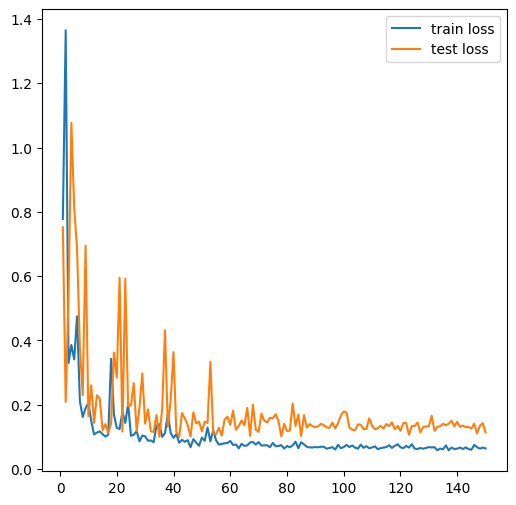

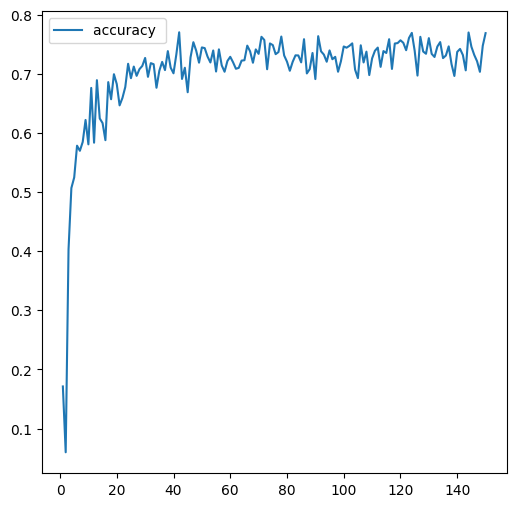

Memory access fault by GPU node-1 (Agent handle: 0x10e2b190) on address 0x757953210000. Reason: Page not present or supervisor privilege.


In [ ]:

trainLoop(model, trainDataLoader, testDataLoader, optimizer, lossFn, steps, device, lrScheluder,scheluderStepsPerEpoch=1)

In [39]:
steps = 40

In [40]:
lrScheluder = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=2e-4, total_steps=steps)

  0%|          | 0/40 [00:00<?, ?it/s]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.3505, SRCC: -0.0915, PLCC: -0.0853, MAE: 0.3489, COS: 0.7795				
  Testing... 8/8, Avg Loss: 0.3142, SRCC: 0.1963, PLCC: 0.1944, MAE: 0.2756, COS: 0.9173				


  2%|▎         | 1/40 [00:30<19:54, 30.62s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.2455, SRCC: 0.0333, PLCC: 0.0399, MAE: 0.2400, COS: 0.8861						
  Testing... 8/8, Avg Loss: 0.2876, SRCC: 0.2209, PLCC: 0.1945, MAE: 0.2593, COS: 0.9217				


  5%|▌         | 2/40 [01:04<20:36, 32.53s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.2916, SRCC: 0.1088, PLCC: 0.1150, MAE: 0.2802, COS: 0.8336				
  Testing... 8/8, Avg Loss: 0.1753, SRCC: 0.3689, PLCC: 0.3643, MAE: 0.1570, COS: 0.9434				


  8%|▊         | 3/40 [01:41<21:15, 34.46s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.2131, SRCC: 0.2477, PLCC: 0.2684, MAE: 0.2007, COS: 0.9151				
  Testing... 8/8, Avg Loss: 0.2334, SRCC: 0.4651, PLCC: 0.4682, MAE: 0.2021, COS: 0.9494				


 10%|█         | 4/40 [02:25<22:52, 38.14s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.1527, SRCC: 0.4880, PLCC: 0.5255, MAE: 0.1504, COS: 0.9495				
  Testing... 8/8, Avg Loss: 0.4435, SRCC: 0.5420, PLCC: 0.5843, MAE: 0.3924, COS: 0.9546				


 12%|█▎        | 5/40 [02:55<20:32, 35.20s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.2026, SRCC: 0.4346, PLCC: 0.4521, MAE: 0.2003, COS: 0.9131				
  Testing... 8/8, Avg Loss: 0.2476, SRCC: 0.6277, PLCC: 0.6702, MAE: 0.2136, COS: 0.9621				


 15%|█▌        | 6/40 [03:26<19:08, 33.79s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.2309, SRCC: 0.4371, PLCC: 0.4651, MAE: 0.2113, COS: 0.9031				
  Testing... 8/8, Avg Loss: 0.2691, SRCC: 0.6032, PLCC: 0.6490, MAE: 0.2305, COS: 0.9616				


 18%|█▊        | 7/40 [03:56<18:01, 32.78s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.2780, SRCC: 0.3294, PLCC: 0.3699, MAE: 0.2733, COS: 0.8551				
  Testing... 8/8, Avg Loss: 0.5704, SRCC: 0.6122, PLCC: 0.6747, MAE: 0.5033, COS: 0.5360				


 20%|██        | 8/40 [04:27<17:09, 32.16s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.2757, SRCC: 0.3468, PLCC: 0.3713, MAE: 0.2614, COS: 0.8785				
  Testing... 8/8, Avg Loss: 0.1540, SRCC: 0.6187, PLCC: 0.6939, MAE: 0.1376, COS: 0.9643				


 22%|██▎       | 9/40 [05:01<16:55, 32.77s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1399, SRCC: 0.6349, PLCC: 0.6707, MAE: 0.1291, COS: 0.9613				
  Testing... 8/8, Avg Loss: 0.6247, SRCC: 0.6702, PLCC: 0.7303, MAE: 0.5448, COS: 0.9599				


 25%|██▌       | 10/40 [05:31<15:56, 31.89s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.2454, SRCC: 0.3461, PLCC: 0.4042, MAE: 0.2383, COS: 0.9008				
  Testing... 8/8, Avg Loss: 0.2666, SRCC: 0.6896, PLCC: 0.7287, MAE: 0.2343, COS: 0.9663				


 28%|██▊       | 11/40 [06:04<15:30, 32.08s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1613, SRCC: 0.5864, PLCC: 0.6157, MAE: 0.1493, COS: 0.9508				
  Testing... 8/8, Avg Loss: 0.3074, SRCC: 0.7018, PLCC: 0.7514, MAE: 0.2713, COS: 0.9379				


 30%|███       | 12/40 [06:36<14:57, 32.06s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1477, SRCC: 0.6149, PLCC: 0.6465, MAE: 0.1418, COS: 0.9548				
  Testing... 8/8, Avg Loss: 0.1766, SRCC: 0.6728, PLCC: 0.6947, MAE: 0.1465, COS: 0.9652				


 32%|███▎      | 13/40 [07:11<14:48, 32.92s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1210, SRCC: 0.7176, PLCC: 0.7349, MAE: 0.1136, COS: 0.9690				
  Testing... 8/8, Avg Loss: 0.1942, SRCC: 0.7191, PLCC: 0.7295, MAE: 0.1702, COS: 0.9686				


 35%|███▌      | 14/40 [08:01<16:32, 38.18s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1222, SRCC: 0.7163, PLCC: 0.7553, MAE: 0.1125, COS: 0.9718				
  Testing... 8/8, Avg Loss: 0.3248, SRCC: 0.7179, PLCC: 0.7428, MAE: 0.2845, COS: 0.9651				


 38%|███▊      | 15/40 [08:43<16:23, 39.32s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1377, SRCC: 0.6325, PLCC: 0.6701, MAE: 0.1352, COS: 0.9608				
  Testing... 8/8, Avg Loss: 0.3045, SRCC: 0.7373, PLCC: 0.7684, MAE: 0.2607, COS: 0.9710				


 40%|████      | 16/40 [09:14<14:46, 36.92s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1348, SRCC: 0.6898, PLCC: 0.7216, MAE: 0.1205, COS: 0.9678				
  Testing... 8/8, Avg Loss: 0.1239, SRCC: 0.7190, PLCC: 0.7378, MAE: 0.1133, COS: 0.9708				


 42%|████▎     | 17/40 [09:45<13:27, 35.09s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.0891, SRCC: 0.8153, PLCC: 0.8349, MAE: 0.0889, COS: 0.9818				
  Testing... 8/8, Avg Loss: 0.2500, SRCC: 0.7185, PLCC: 0.7264, MAE: 0.2188, COS: 0.9595				


 45%|████▌     | 18/40 [10:16<12:23, 33.81s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.1174, SRCC: 0.7553, PLCC: 0.7727, MAE: 0.1085, COS: 0.9726				
  Testing... 8/8, Avg Loss: 0.1290, SRCC: 0.7466, PLCC: 0.7841, MAE: 0.1095, COS: 0.9753				


 48%|████▊     | 19/40 [10:49<11:44, 33.55s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.0952, SRCC: 0.8086, PLCC: 0.8360, MAE: 0.0914, COS: 0.9813				
  Testing... 8/8, Avg Loss: 0.1120, SRCC: 0.7858, PLCC: 0.8146, MAE: 0.0975, COS: 0.9786				


 50%|█████     | 20/40 [11:20<10:54, 32.74s/it]

  Testing... 30/30, lr 0.0002, Avg Loss: 0.0917, SRCC: 0.8485, PLCC: 0.8658, MAE: 0.0809, COS: 0.9849				
  Testing... 8/8, Avg Loss: 0.2739, SRCC: 0.7311, PLCC: 0.7658, MAE: 0.2338, COS: 0.9713				


 52%|█████▎    | 21/40 [11:55<10:34, 33.39s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.1085, SRCC: 0.7905, PLCC: 0.7971, MAE: 0.1043, COS: 0.9760				
  Testing... 8/8, Avg Loss: 0.1204, SRCC: 0.7531, PLCC: 0.7724, MAE: 0.1055, COS: 0.9742				


 55%|█████▌    | 22/40 [12:37<10:50, 36.13s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0846, SRCC: 0.8439, PLCC: 0.8590, MAE: 0.0825, COS: 0.9840				
  Testing... 8/8, Avg Loss: 0.3327, SRCC: 0.7451, PLCC: 0.7556, MAE: 0.2973, COS: 0.9683				


 57%|█████▊    | 23/40 [13:07<09:42, 34.28s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.1308, SRCC: 0.7413, PLCC: 0.7592, MAE: 0.1172, COS: 0.9700				
  Testing... 8/8, Avg Loss: 0.1205, SRCC: 0.7528, PLCC: 0.7715, MAE: 0.1052, COS: 0.9741				


 60%|██████    | 24/40 [13:36<08:44, 32.80s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0959, SRCC: 0.8126, PLCC: 0.8317, MAE: 0.0891, COS: 0.9811				
  Testing... 8/8, Avg Loss: 0.1227, SRCC: 0.7642, PLCC: 0.7782, MAE: 0.1059, COS: 0.9741				


 62%|██████▎   | 25/40 [14:08<08:08, 32.59s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0879, SRCC: 0.8411, PLCC: 0.8543, MAE: 0.0837, COS: 0.9836				
  Testing... 8/8, Avg Loss: 0.1185, SRCC: 0.7365, PLCC: 0.7566, MAE: 0.1066, COS: 0.9725				


 65%|██████▌   | 26/40 [14:44<07:47, 33.39s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0699, SRCC: 0.8919, PLCC: 0.9002, MAE: 0.0666, COS: 0.9889				
  Testing... 8/8, Avg Loss: 0.1402, SRCC: 0.7461, PLCC: 0.7678, MAE: 0.1280, COS: 0.9720				


 68%|██████▊   | 27/40 [15:15<07:07, 32.85s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0710, SRCC: 0.8998, PLCC: 0.9065, MAE: 0.0641, COS: 0.9896				
  Testing... 8/8, Avg Loss: 0.1639, SRCC: 0.7920, PLCC: 0.8180, MAE: 0.1409, COS: 0.9772				


 70%|███████   | 28/40 [15:45<06:22, 31.89s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0796, SRCC: 0.8757, PLCC: 0.8881, MAE: 0.0742, COS: 0.9873				
  Testing... 8/8, Avg Loss: 0.1168, SRCC: 0.7416, PLCC: 0.7798, MAE: 0.1016, COS: 0.9750				


 72%|███████▎  | 29/40 [16:16<05:46, 31.48s/it]

  Testing... 30/30, lr 0.0001, Avg Loss: 0.0767, SRCC: 0.8671, PLCC: 0.8860, MAE: 0.0734, COS: 0.9873				
  Testing... 8/8, Avg Loss: 0.1546, SRCC: 0.7597, PLCC: 0.7804, MAE: 0.1369, COS: 0.9733				


 75%|███████▌  | 30/40 [17:49<08:19, 49.98s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0946, SRCC: 0.8199, PLCC: 0.8325, MAE: 0.0941, COS: 0.9809				
  Testing... 8/8, Avg Loss: 0.1128, SRCC: 0.7612, PLCC: 0.7874, MAE: 0.1010, COS: 0.9752				


 78%|███████▊  | 31/40 [18:21<06:41, 44.65s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0726, SRCC: 0.8787, PLCC: 0.8967, MAE: 0.0687, COS: 0.9885				
  Testing... 8/8, Avg Loss: 0.1096, SRCC: 0.7744, PLCC: 0.7967, MAE: 0.1001, COS: 0.9764				


 80%|████████  | 32/40 [18:51<05:22, 40.26s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0649, SRCC: 0.9022, PLCC: 0.9174, MAE: 0.0613, COS: 0.9907				
  Testing... 8/8, Avg Loss: 0.1391, SRCC: 0.7552, PLCC: 0.7878, MAE: 0.1179, COS: 0.9753				


 82%|████████▎ | 33/40 [19:22<04:21, 37.43s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0662, SRCC: 0.9014, PLCC: 0.9153, MAE: 0.0637, COS: 0.9904				
  Testing... 8/8, Avg Loss: 0.1185, SRCC: 0.7479, PLCC: 0.7665, MAE: 0.1059, COS: 0.9737				


 85%|████████▌ | 34/40 [19:53<03:33, 35.65s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0628, SRCC: 0.9173, PLCC: 0.9295, MAE: 0.0573, COS: 0.9920				
  Testing... 8/8, Avg Loss: 0.1300, SRCC: 0.7621, PLCC: 0.7852, MAE: 0.1124, COS: 0.9747				


 88%|████████▊ | 35/40 [20:23<02:48, 33.74s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0577, SRCC: 0.9230, PLCC: 0.9326, MAE: 0.0567, COS: 0.9924				
  Testing... 8/8, Avg Loss: 0.1206, SRCC: 0.7461, PLCC: 0.7769, MAE: 0.1061, COS: 0.9745				


 90%|█████████ | 36/40 [20:52<02:10, 32.51s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0597, SRCC: 0.9287, PLCC: 0.9353, MAE: 0.0549, COS: 0.9927				
  Testing... 8/8, Avg Loss: 0.1304, SRCC: 0.7252, PLCC: 0.7677, MAE: 0.1123, COS: 0.9728				


 92%|█████████▎| 37/40 [21:22<01:34, 31.57s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0691, SRCC: 0.9182, PLCC: 0.9277, MAE: 0.0580, COS: 0.9918				
  Testing... 8/8, Avg Loss: 0.1218, SRCC: 0.7413, PLCC: 0.7754, MAE: 0.1074, COS: 0.9742				


 95%|█████████▌| 38/40 [21:51<01:02, 31.00s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0582, SRCC: 0.9286, PLCC: 0.9357, MAE: 0.0545, COS: 0.9927				
  Testing... 8/8, Avg Loss: 0.1170, SRCC: 0.7868, PLCC: 0.8202, MAE: 0.0975, COS: 0.9789				


 98%|█████████▊| 39/40 [22:20<00:30, 30.41s/it]

  Testing... 30/30, lr 0.0000, Avg Loss: 0.0665, SRCC: 0.9195, PLCC: 0.9290, MAE: 0.0572, COS: 0.9920				
  Testing... 8/8, Avg Loss: 0.1123, SRCC: 0.7441, PLCC: 0.8015, MAE: 0.1010, COS: 0.9769				


100%|██████████| 40/40 [22:50<00:00, 34.26s/it]


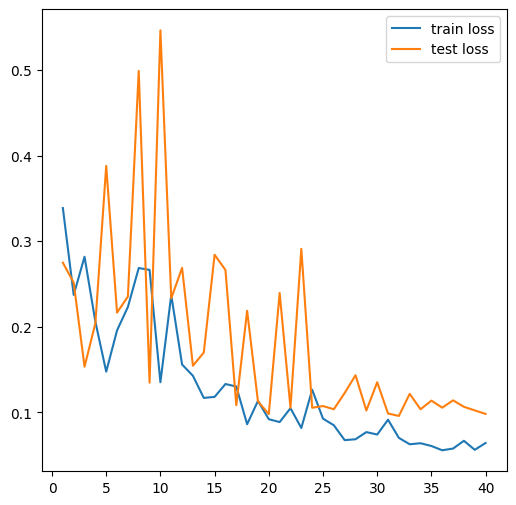

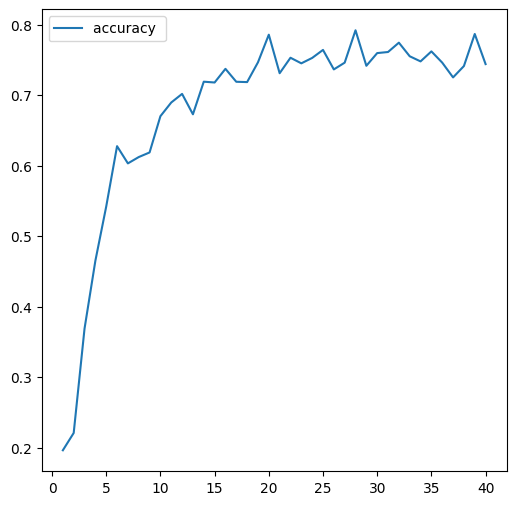

In [41]:

trainLoop(model, trainDataLoader, testDataLoader, optimizer, lossFn, steps, device, lrScheluder,scheluderStepsPerEpoch=1)